In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from dark.dimension import dimensionalIterator
from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import rasterio

from giscode.common import NODATAVAL

# Analysis, AP3

This notebook contains of the remote sensing images that were used for the final analyses, and a look at the population data to investigate the intersection between areas with people > 65 and areas of high temperatures.

## Visual inspection of satellite images

In [3]:
files = [
 '../../data/landsat/resolution/LC08_L2SP_194027_20220623_20220705_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC08_L2SP_195027_20220716_20220726_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC09_L2SP_194027_20220717_20230407_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC08_L2SP_194027_20220725_20220802_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC08_L2SP_195027_20220801_20220806_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC09_L2SP_194027_20220802_20230404_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC09_L2SP_195027_20220809_20230403_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC08_L2SP_194027_20220810_20220818_02_T1_ST_B10-resolution.TIF']

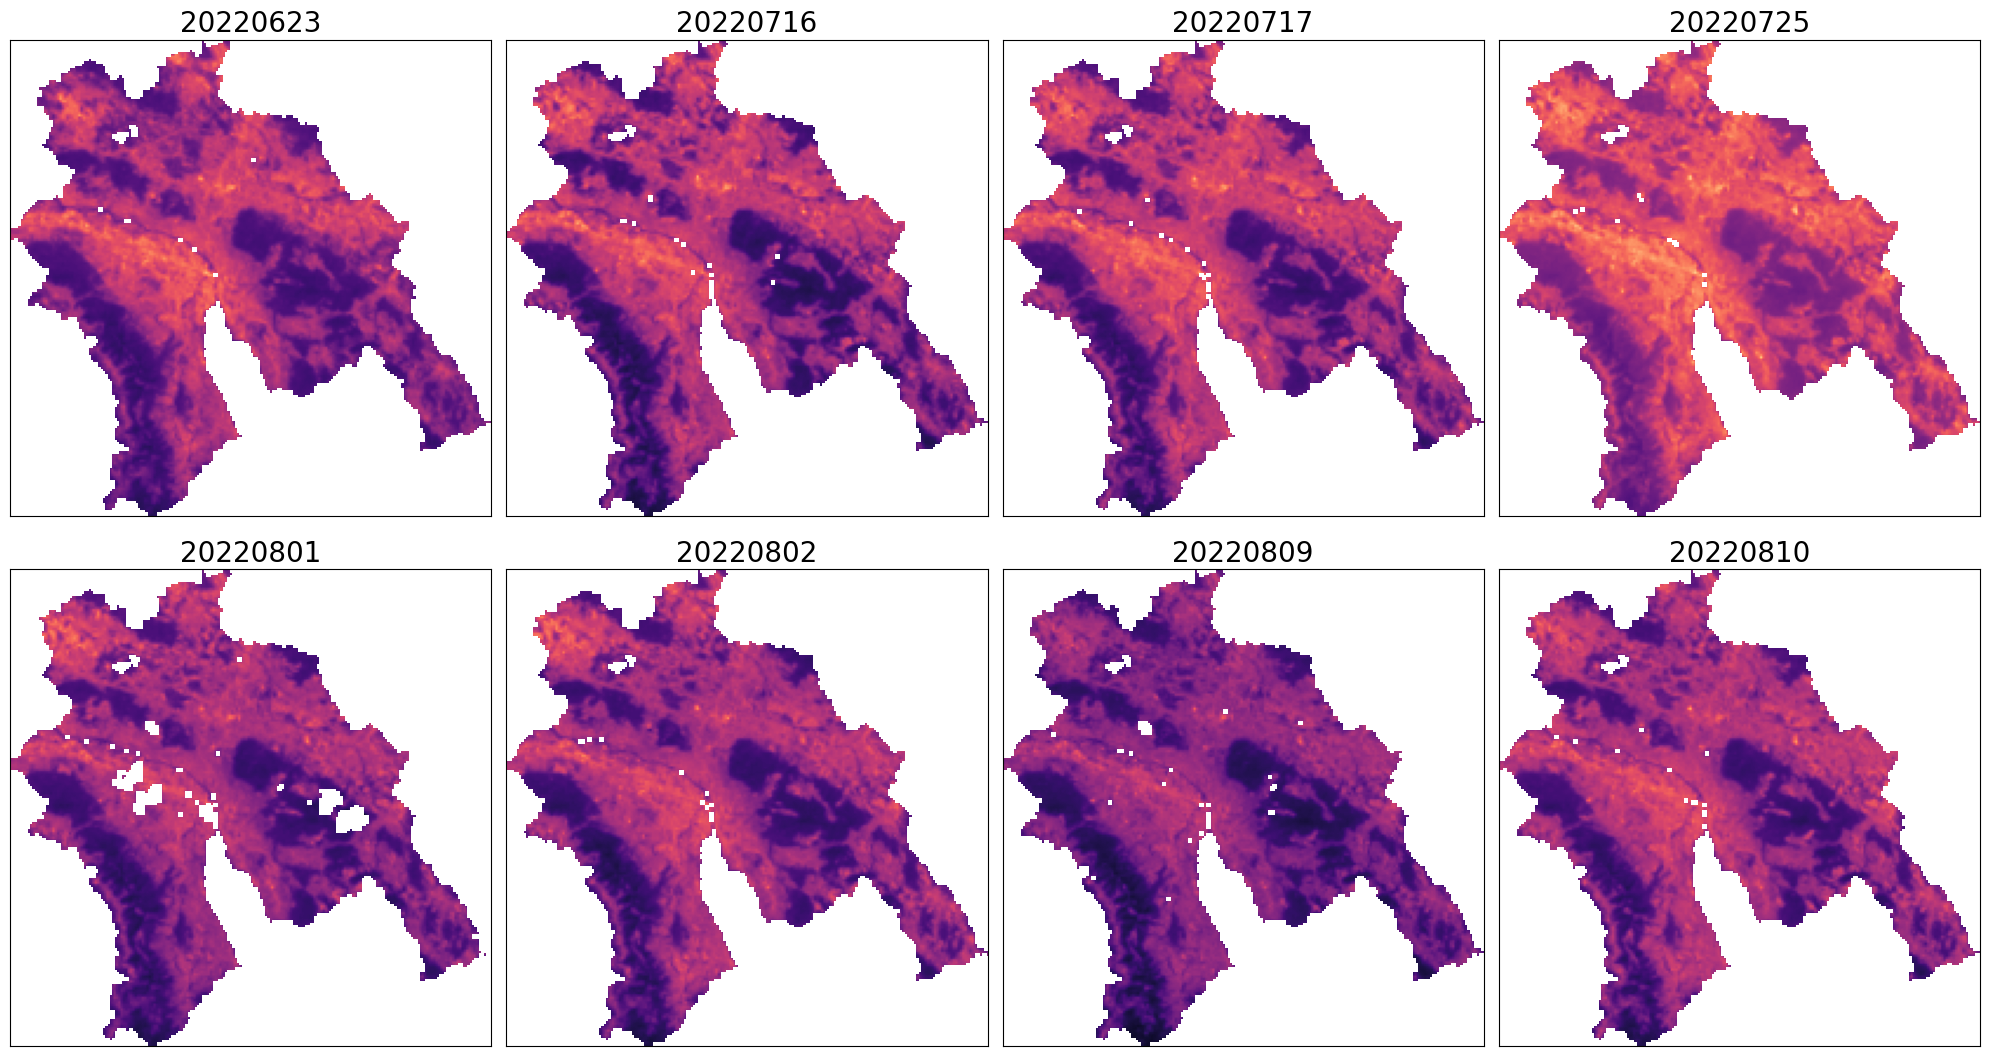

In [51]:
fig, ax = plt.subplots(2, 4, figsize = (20, 11))

coords = dimensionalIterator((2, 4))

for file in files:
    row, col = next(coords)
    ls = rasterio.open(file)

    d = ls.read(1)
    d[d == NODATAVAL] = np.nan
    title = file.split('_')[3]

    im = ax[row][col].imshow(d, cmap='magma', vmin=20, vmax=55)
    
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
    ax[row][col].set_title(file.split('_')[3], fontsize=20)
    #fig.colorbar(im, ax=ax[row][col])
    ls.close()

plt.tight_layout()

--> Eyeballing this, hot and cold areas tend to be in similar places.

--> I think I can average the images based on this. It would also agree with the findings from the sensors, which find good correlation of temperature measurements taken at the same sites but on different days with actual measured temperature.

--> All selected days are 'heatdays' where the maximum temperature measured by any sensor was >30C. Therefore, selecting satellite images based on whether they were taken on a heat day is not possible.

## Average satellite images

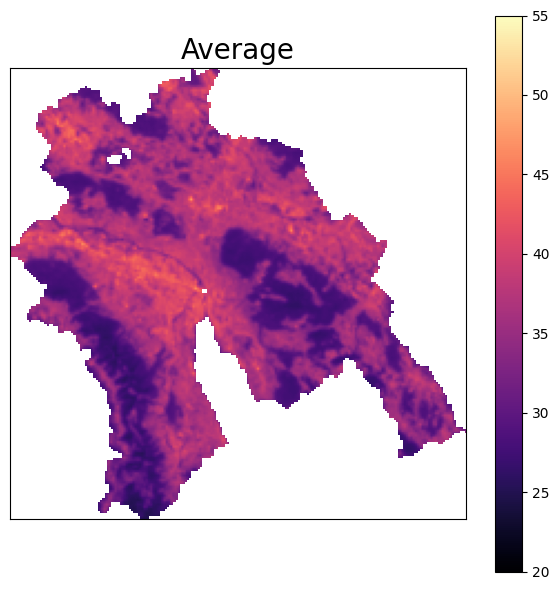

In [36]:
fig, ax = plt.subplots(figsize = (6, 6))

tempRaster = rasterio.open('../../data/landsat/resolution/average-resolution.TIF')

arr = tempRaster.read(1)

im = ax.imshow(arr, cmap='magma', vmin=20, vmax=55)
    
ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Average', fontsize=20)
fig.colorbar(im, ax=ax)

plt.tight_layout()
tempRaster.close()

## Aggregate temperature and population data

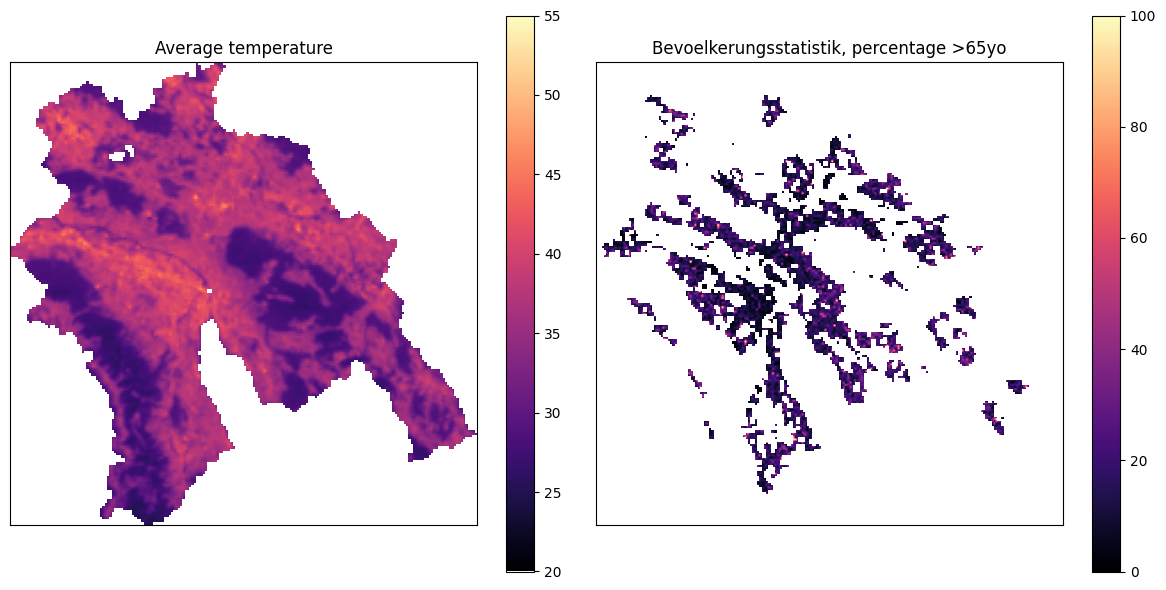

In [121]:
# Plots of satellite data and population data next to each other

fig, ax = plt.subplots(1, 2, figsize = (12, 6))

# Satellite data
im = ax[0].imshow(arr, cmap='magma', vmin=20, vmax=55)
    
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Average temperature')
fig.colorbar(im, ax=ax[0])

# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(1)
d[d == NODATAVAL] = np.nan

im = ax[1].imshow(d, cmap='magma', vmin=0, vmax=100)

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Bevoelkerungsstatistik, percentage >65yo')

fig.colorbar(im, ax=ax[1])
ls.close()

plt.tight_layout()

plt.savefig('temp-bev-small.png')

--> Note that the population image above hides some of the data, maybe due to the lower resolution. Compare to the plot below, which shows more granularity.

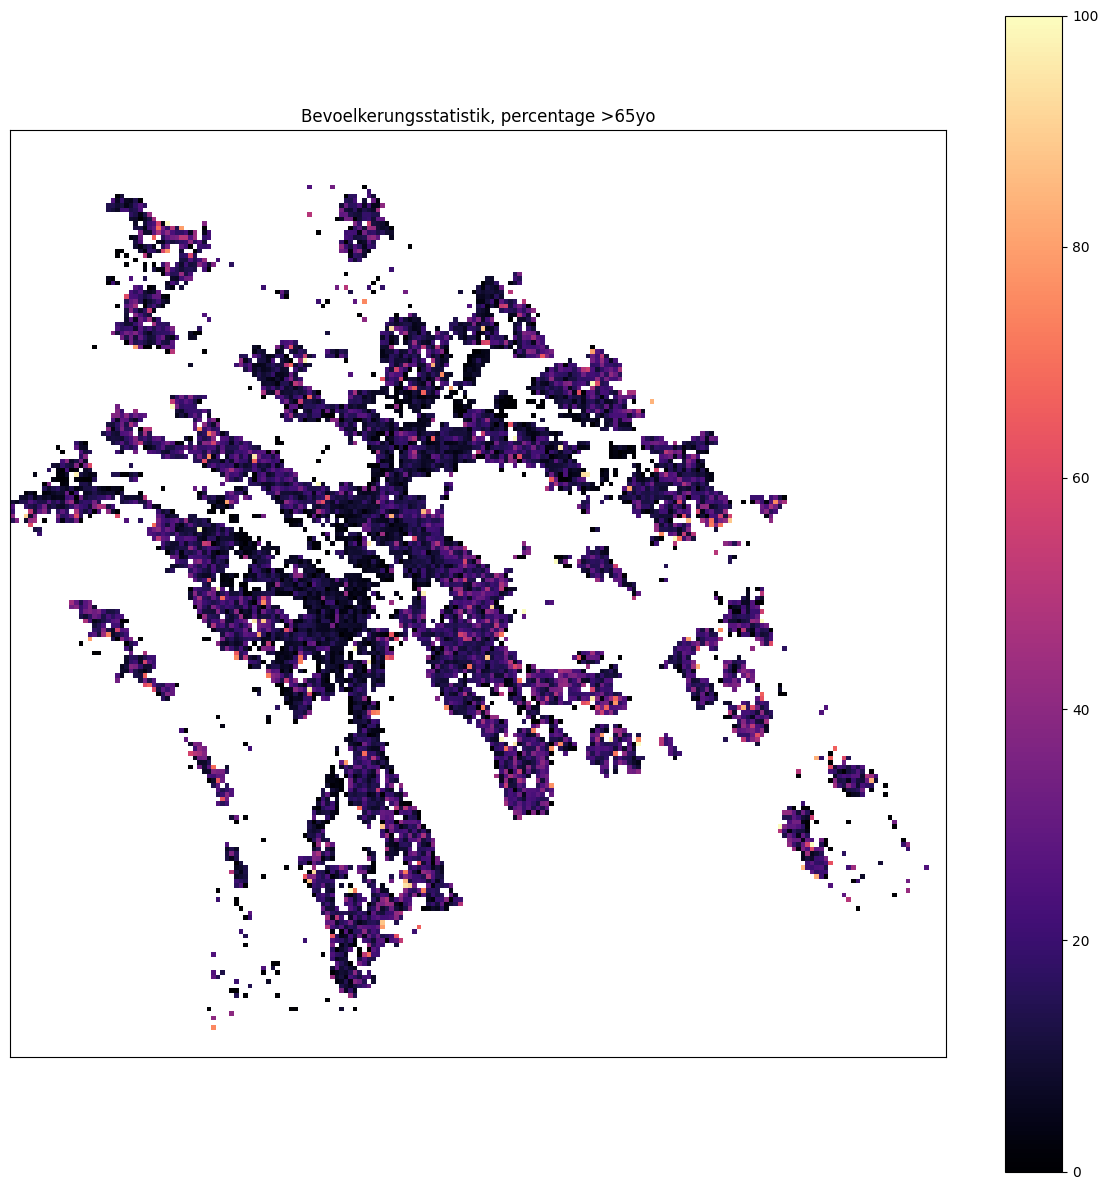

In [119]:
fig, ax = plt.subplots(figsize = (12, 12))

ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(1)
d[d == NODATAVAL] = np.nan
title = file.split('_')[3]

im = ax.imshow(d, cmap='magma', vmin=0, vmax=100)

ax.set_xticks([])
ax.set_yticks([])
ax.set_title('Bevoelkerungsstatistik, percentage >65yo')

fig.colorbar(im, ax=ax)
ls.close()

plt.tight_layout()

plt.savefig('bev-large.png')

Below is the same figure, but at higher resolution --> much better.

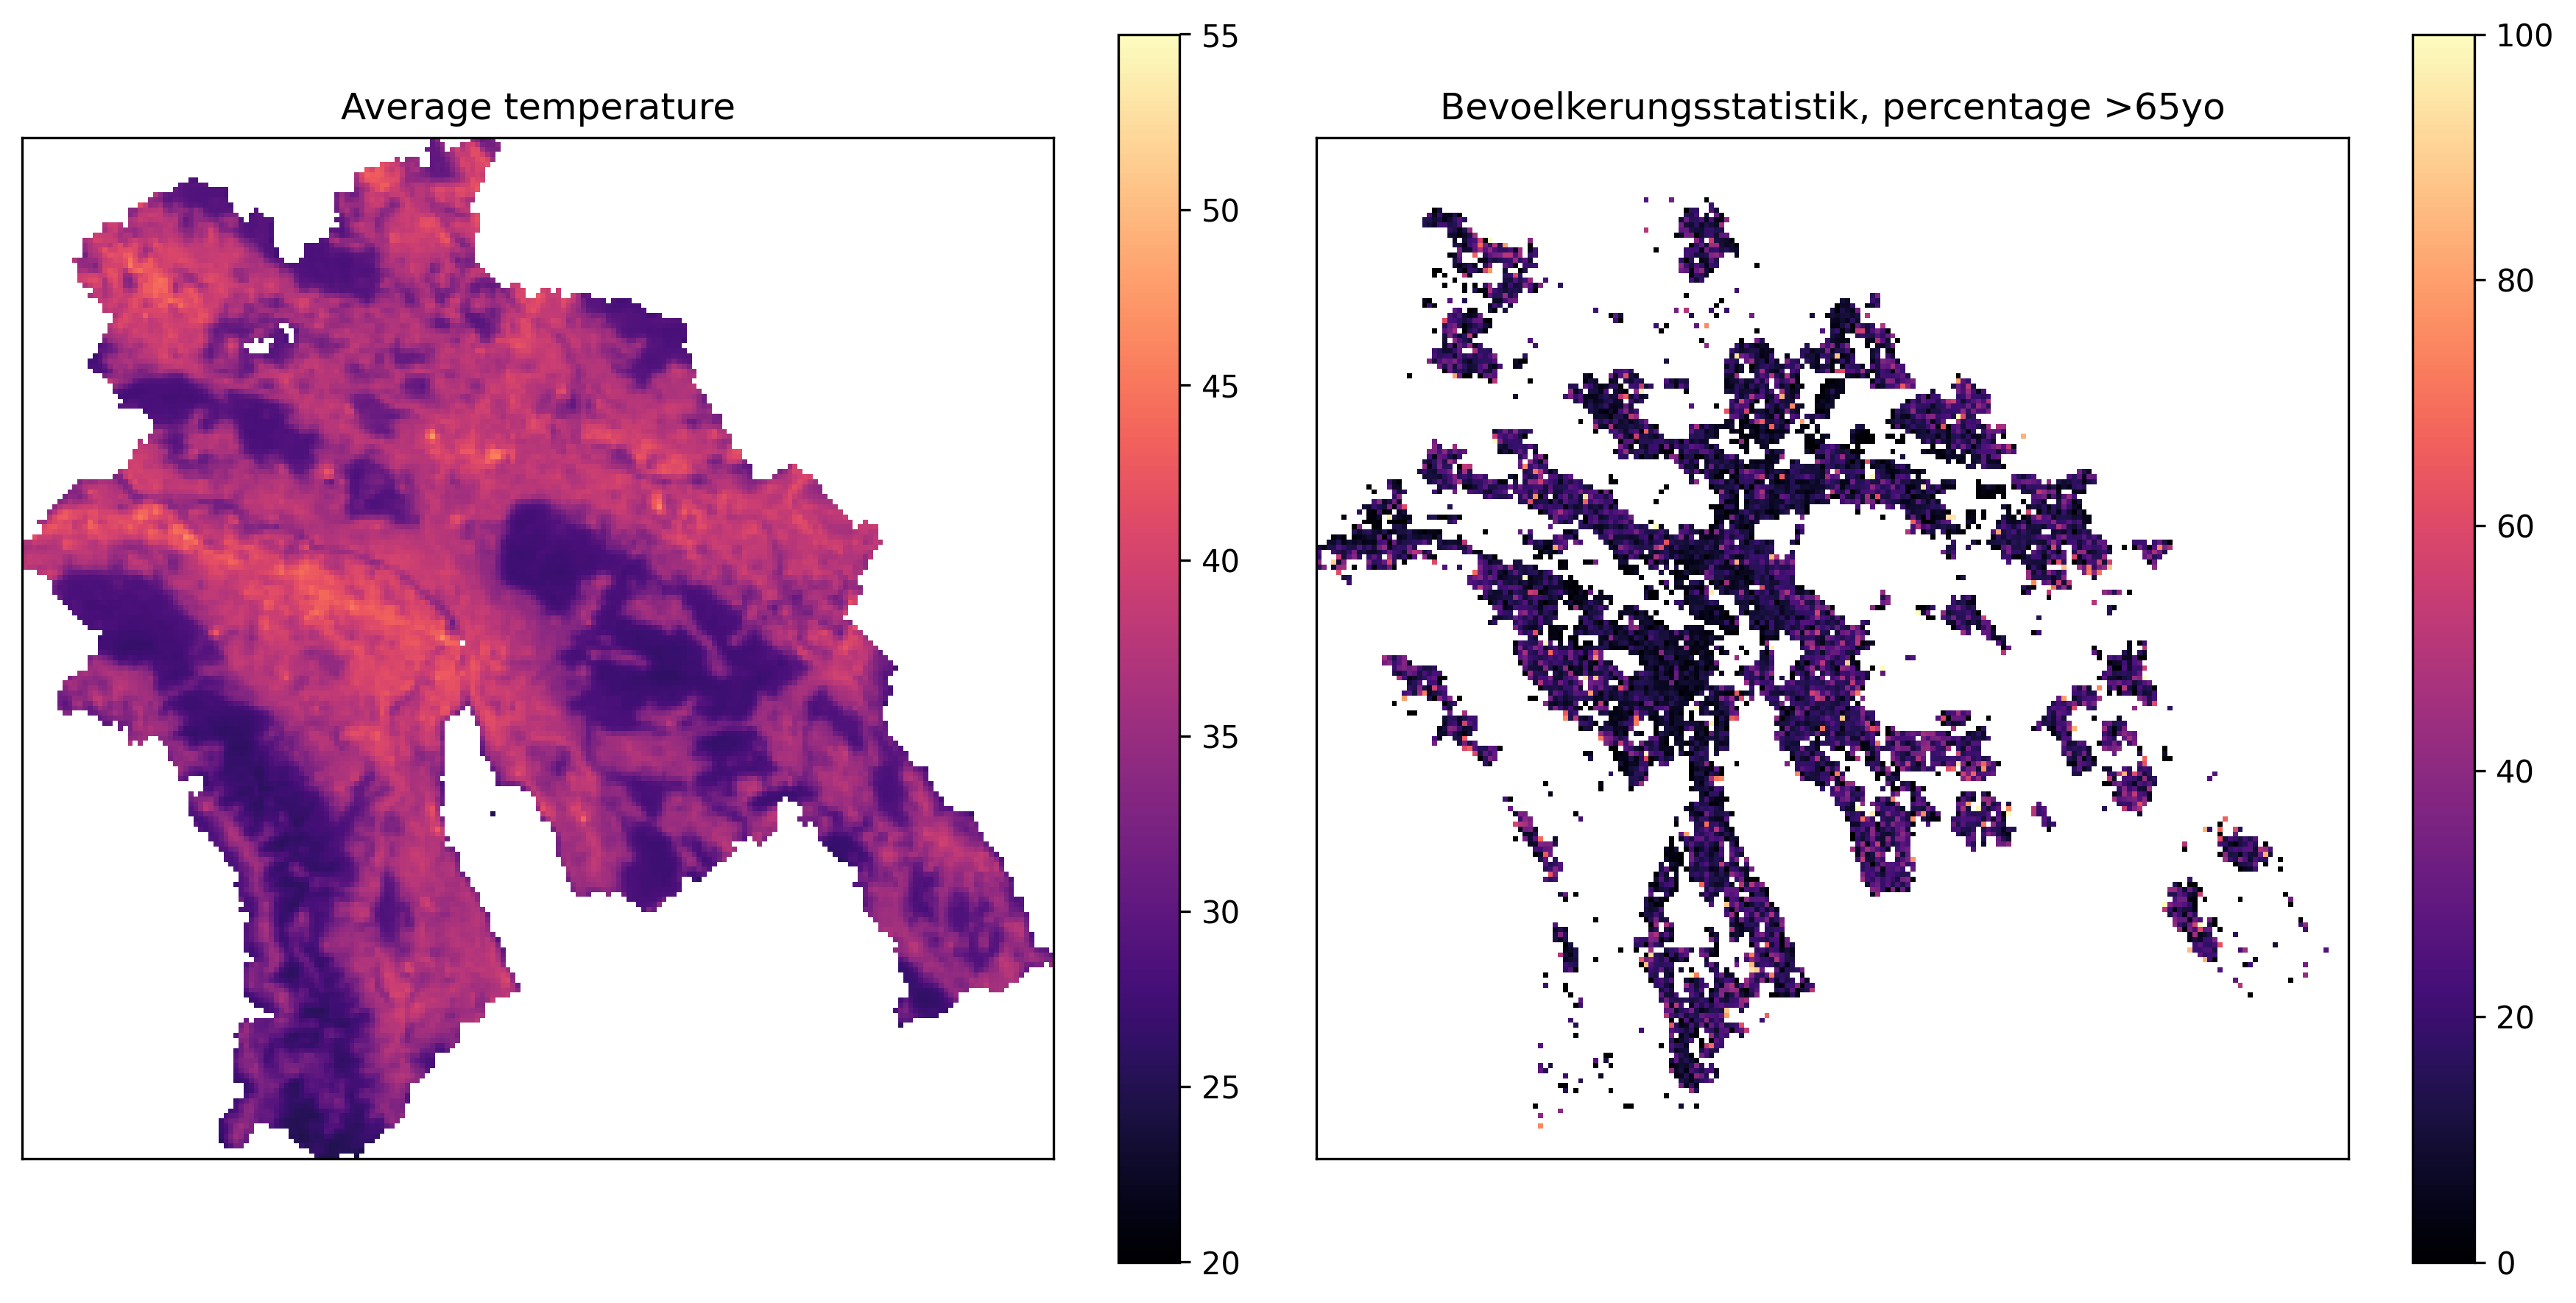

In [120]:
fig, ax = plt.subplots(1, 2, figsize = (12, 6), dpi=300)

# Satellite data
im = ax[0].imshow(arr, cmap='magma', vmin=20, vmax=55)
    
ax[0].set_xticks([])
ax[0].set_yticks([])
ax[0].set_title('Average temperature')
fig.colorbar(im, ax=ax[0])

# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(1)
d[d == NODATAVAL] = np.nan

im = ax[1].imshow(d, cmap='magma', vmin=0, vmax=100)

ax[1].set_xticks([])
ax[1].set_yticks([])
ax[1].set_title('Bevoelkerungsstatistik, percentage >65yo')

fig.colorbar(im, ax=ax[1])
ls.close()

plt.tight_layout()

plt.savefig('temp-bev.png')
plt.savefig('temp-bev.pdf')

How to figure out which areas with older people are hotter? I need some cut-off which areas with old people I consider relevant. For now, let's try to look at areas with an above average proportion of older people.

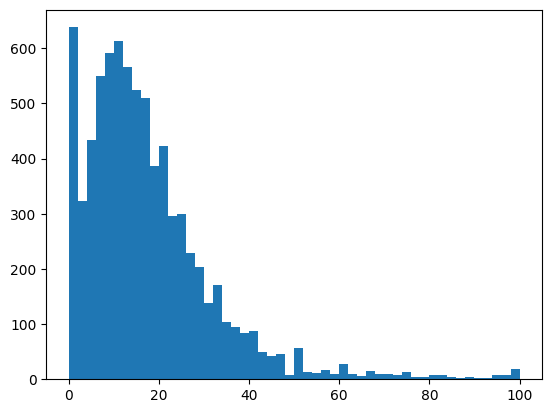

In [146]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(1)
d[d == NODATAVAL] = np.nan

plt.hist(d.flatten(), bins=50)

ls.close()

On average, there are 17.46% old people in a raster cell.


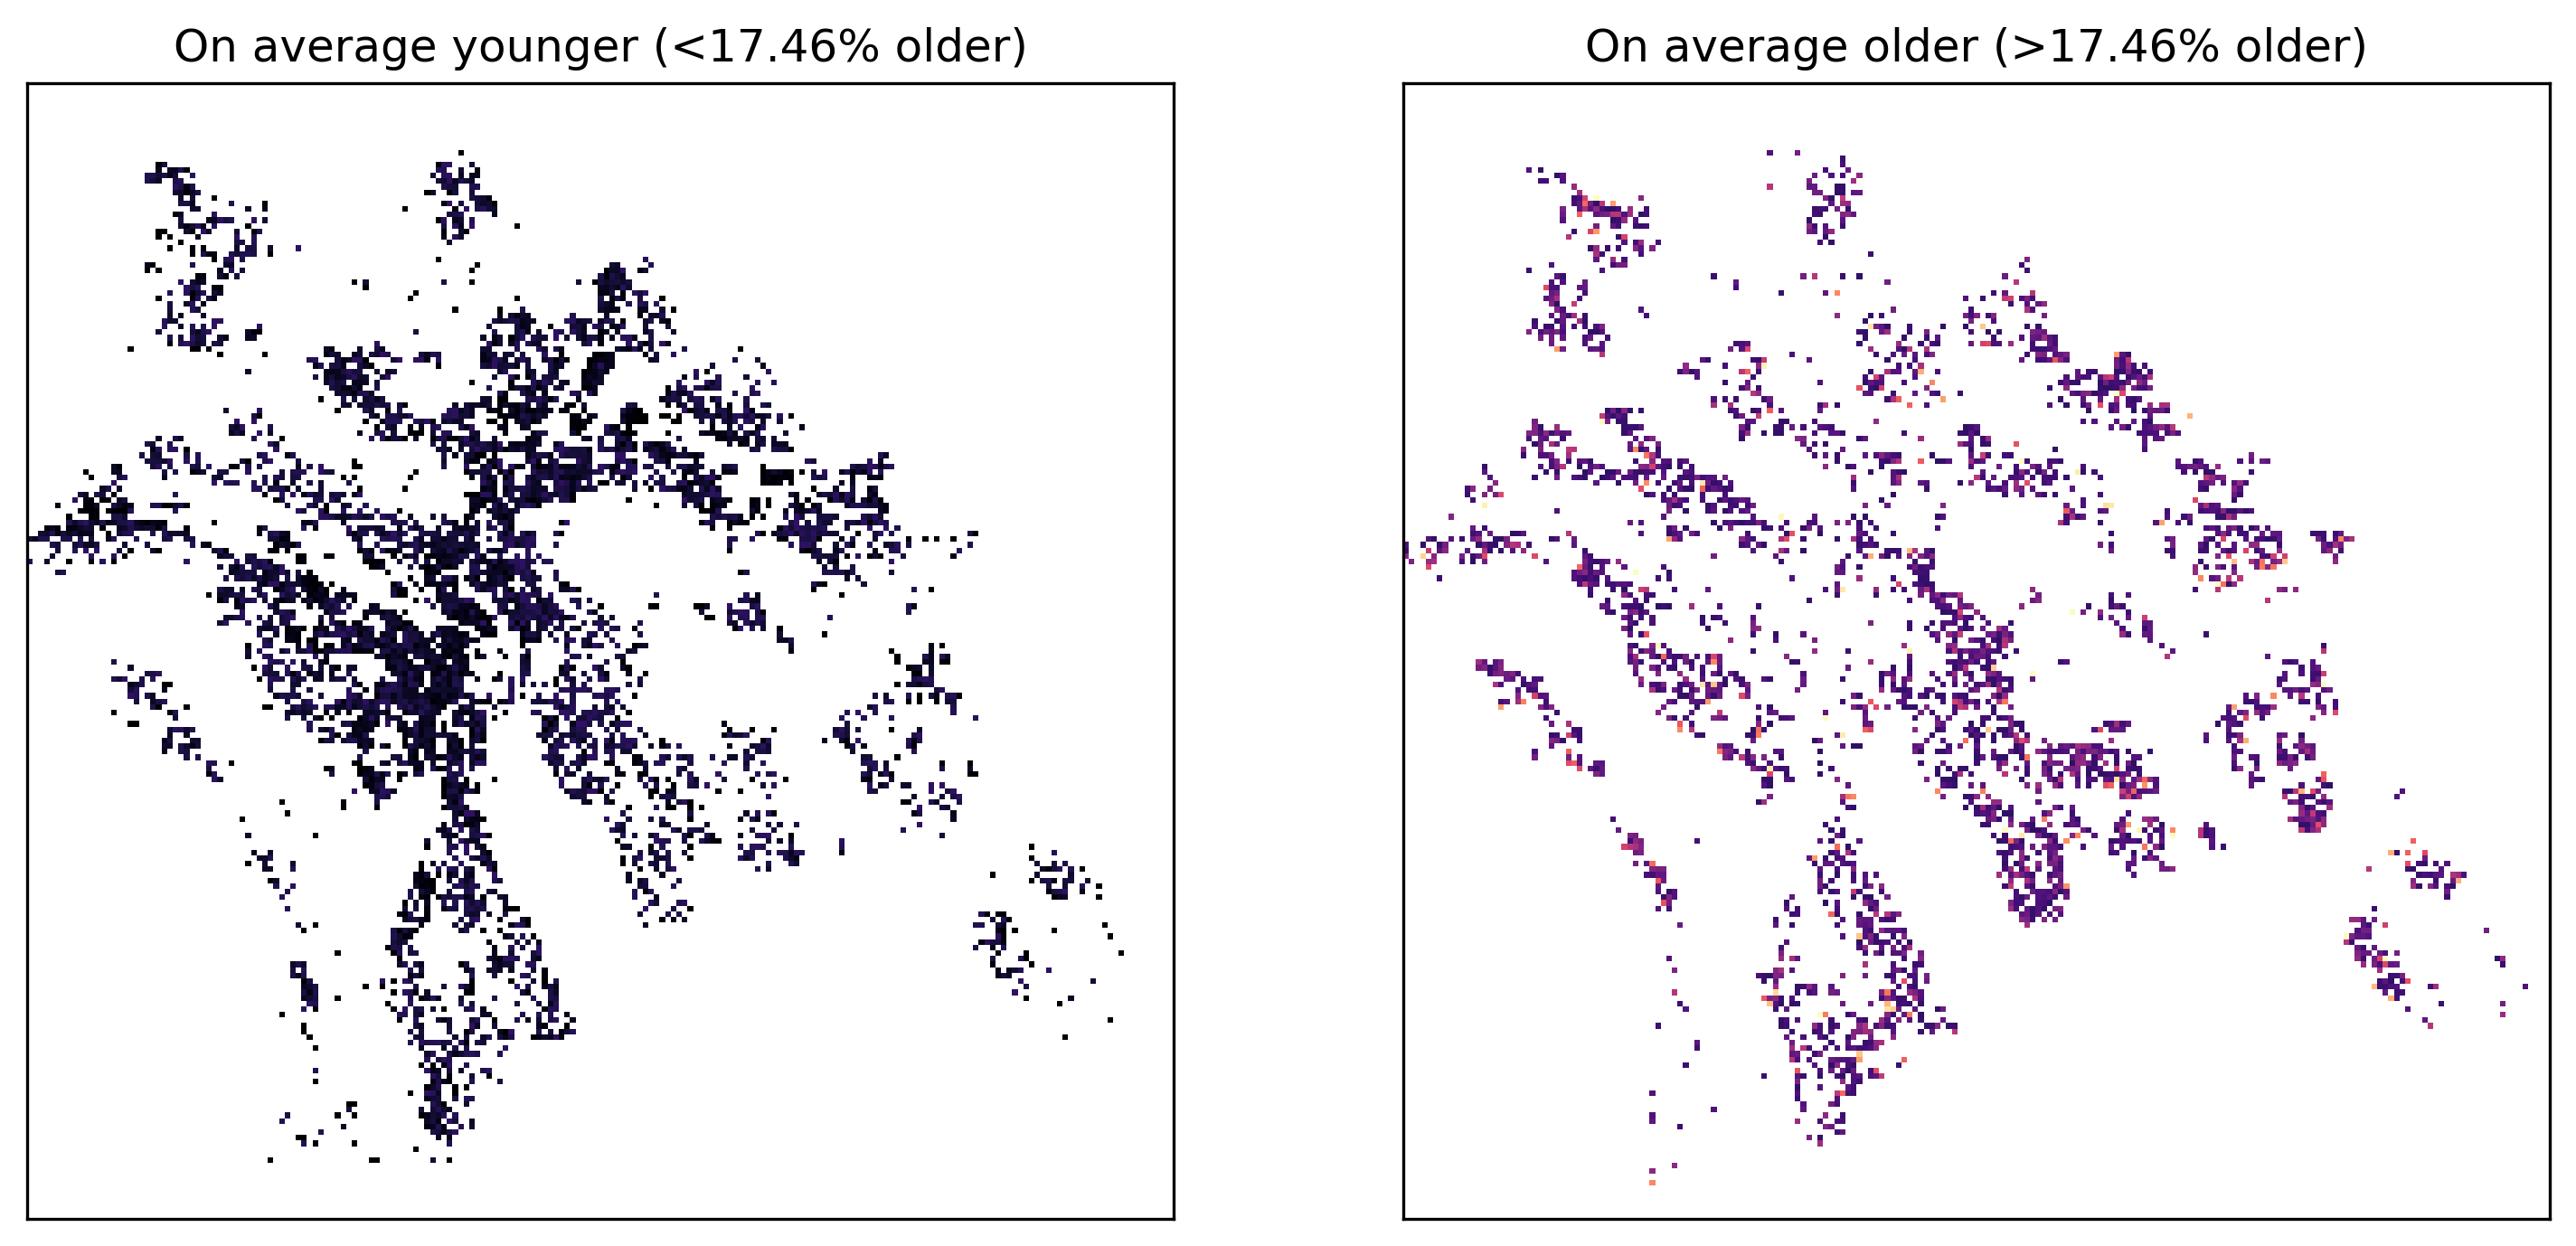

In [150]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(1)
d[d == NODATAVAL] = np.nan

meanold = np.nanmean(d.flatten())

print(f'On average, there are {meanold:.2f}% old people in a raster cell.')

# mask out the younger areas

d[d <= meanold] = np.nan

fig, ax = plt.subplots(1, 2, figsize = (12, 6), dpi=300)

im = ax[1].imshow(d, cmap='magma', vmin=0, vmax=100)

ax[1].set_title('On average older (>17.46% older)')
ax[1].set_xticks([])
ax[1].set_yticks([])
#ax.set_title('Bevoelkerungsstatistik, percentage >65yo')

#fig.colorbar(im, ax=ax[1])


# Mask out older areas
d = ls.read(1)
d[d == NODATAVAL] = np.nan

d[d > meanold] = np.nan

im = ax[0].imshow(d, cmap='magma', vmin=0, vmax=100)

ax[0].set_title('On average younger (<17.46% older)')
ax[0].set_xticks([])
ax[0].set_yticks([])

ls.close()

--> Interesting that it does look like there's some clustering, with younger people more in the centre, and towards Oerlikon and Glattbrugg. The effect is weaker for the older people although it looks like there's a higher proportion on the north side of the lake.

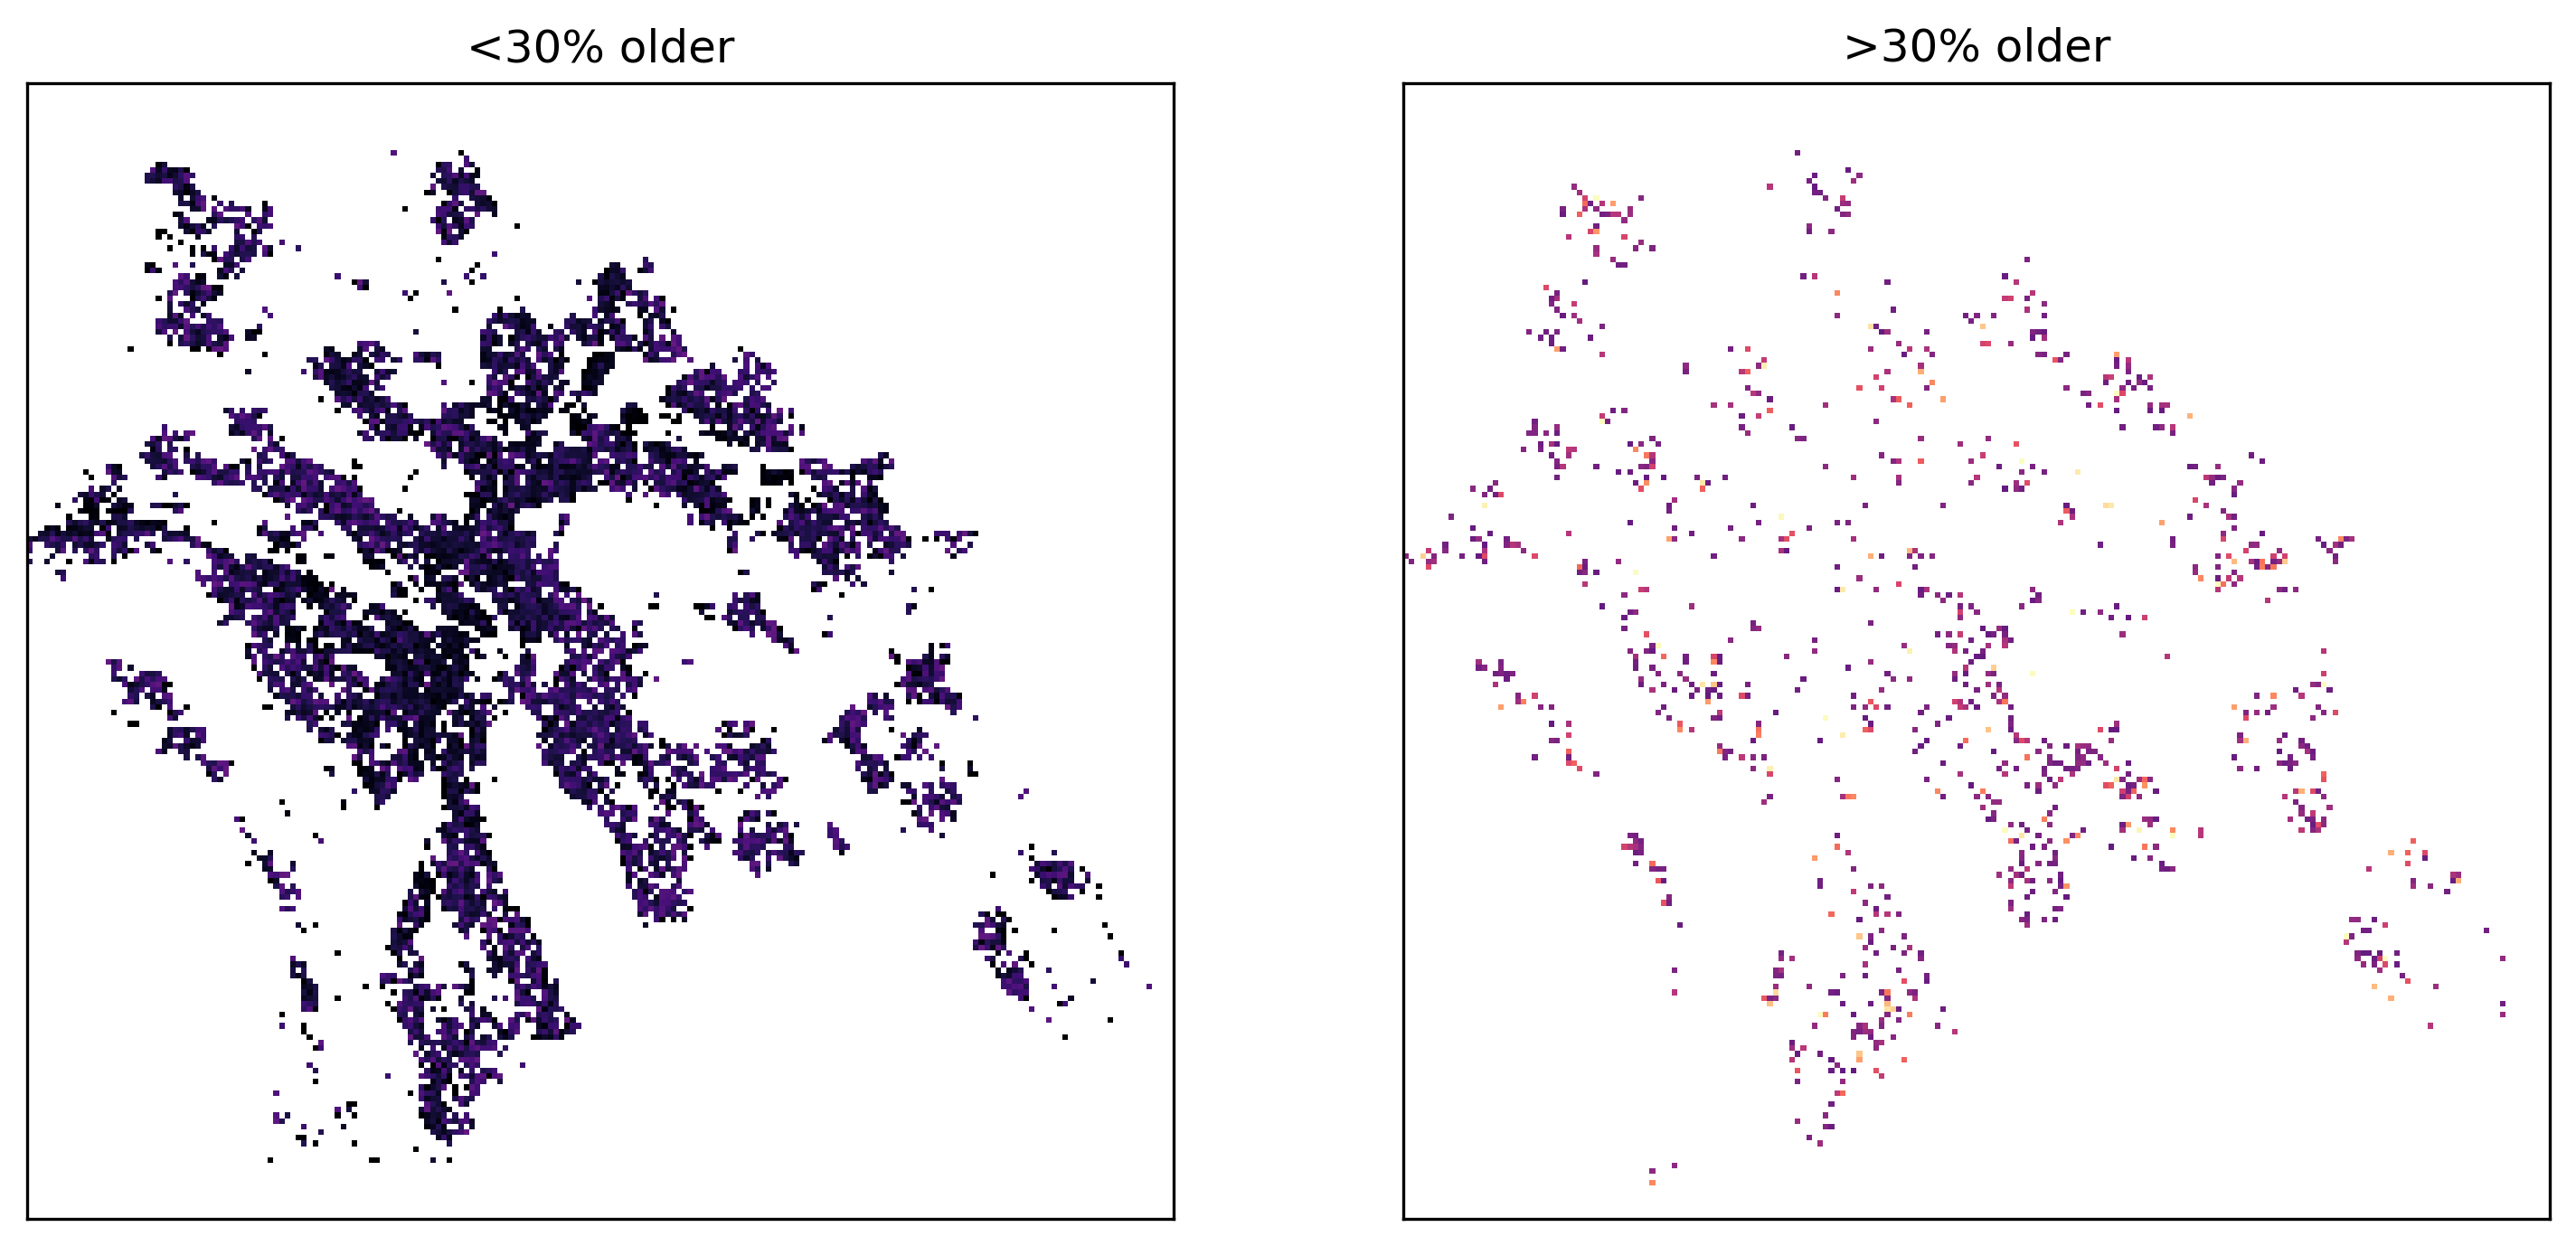

In [147]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(1)
d[d == NODATAVAL] = np.nan

# mask out the younger areas

d[d <= 30] = np.nan

fig, ax = plt.subplots(1, 2, figsize = (12, 6), dpi=300)

im = ax[1].imshow(d, cmap='magma', vmin=0, vmax=100)

ax[1].set_title('>30% older')
ax[1].set_xticks([])
ax[1].set_yticks([])
#ax.set_title('Bevoelkerungsstatistik, percentage >65yo')

#fig.colorbar(im, ax=ax[1])


# Mask out older areas
d = ls.read(1)
d[d == NODATAVAL] = np.nan

d[d > 30] = np.nan

im = ax[0].imshow(d, cmap='magma', vmin=0, vmax=100)

ax[0].set_title('<30% older')
ax[0].set_xticks([])
ax[0].set_yticks([])

ls.close()

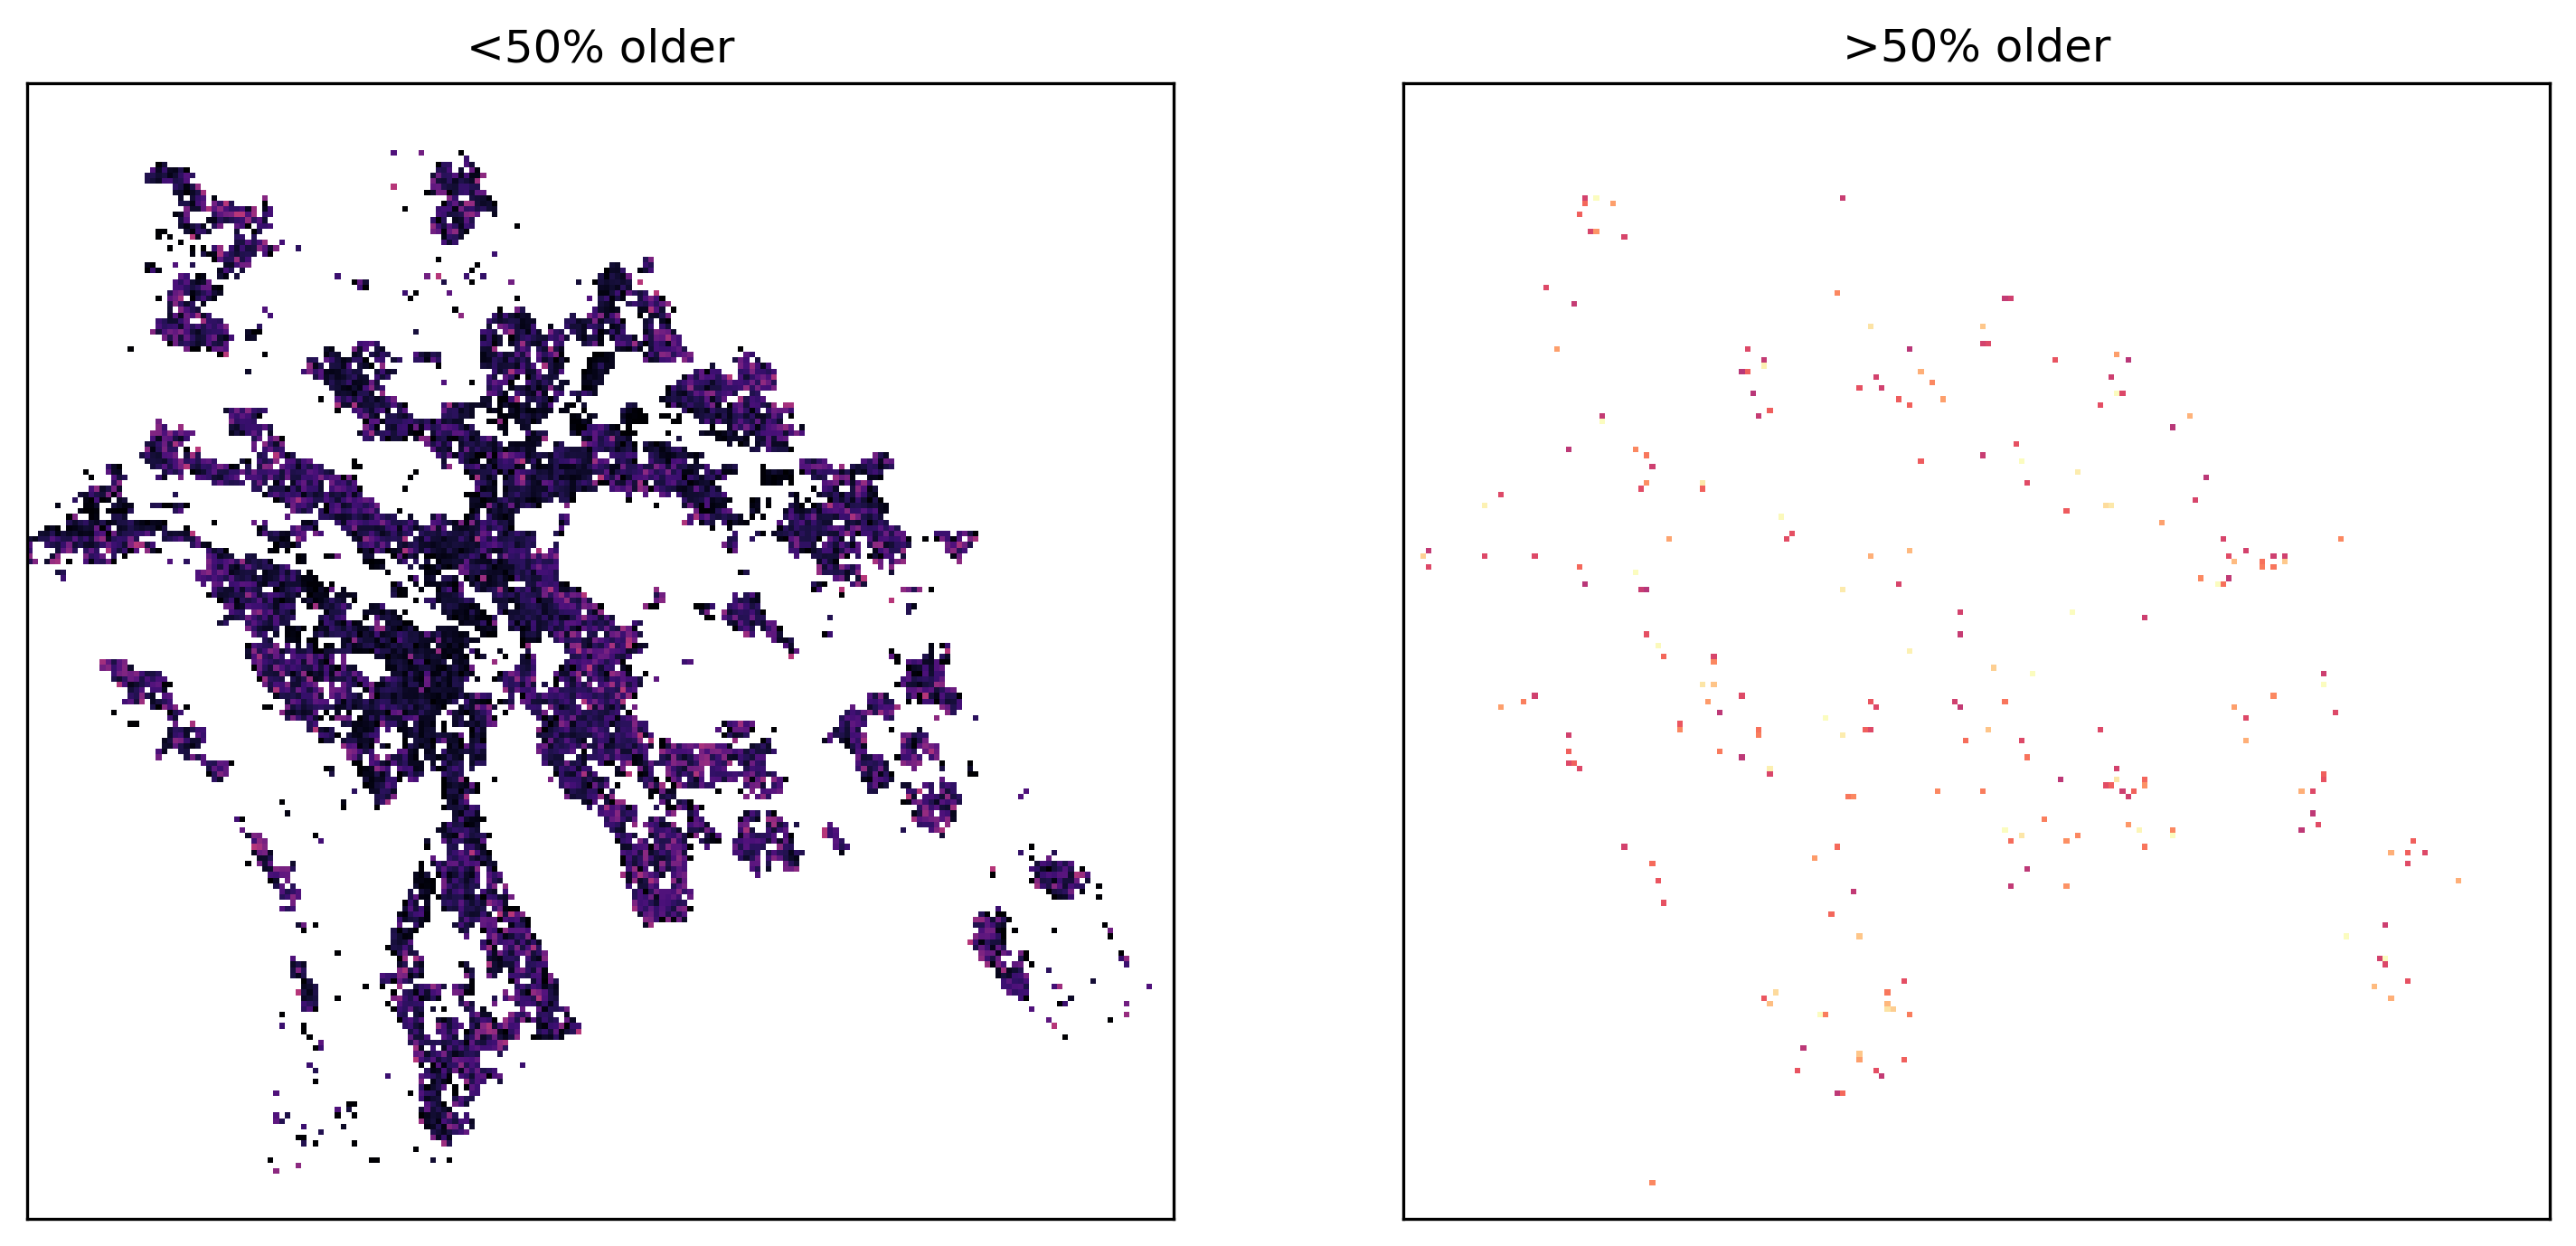

In [148]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(1)
d[d == NODATAVAL] = np.nan

# mask out the younger areas

d[d <= 50] = np.nan

fig, ax = plt.subplots(1, 2, figsize = (12, 6), dpi=300)

im = ax[1].imshow(d, cmap='magma', vmin=0, vmax=100)

ax[1].set_title('>50% older')
ax[1].set_xticks([])
ax[1].set_yticks([])
#ax.set_title('Bevoelkerungsstatistik, percentage >65yo')

#fig.colorbar(im, ax=ax[1])


# Mask out older areas
d = ls.read(1)
d[d == NODATAVAL] = np.nan

d[d > 50] = np.nan

im = ax[0].imshow(d, cmap='magma', vmin=0, vmax=100)

ax[0].set_title('<50% older')
ax[0].set_xticks([])
ax[0].set_yticks([])

ls.close()

--> I wonder if percentage of older people is a good metric to look at. Maybe absolute number of older people is better. If 100% old people corresponds to 1 person, that's obviously not great.

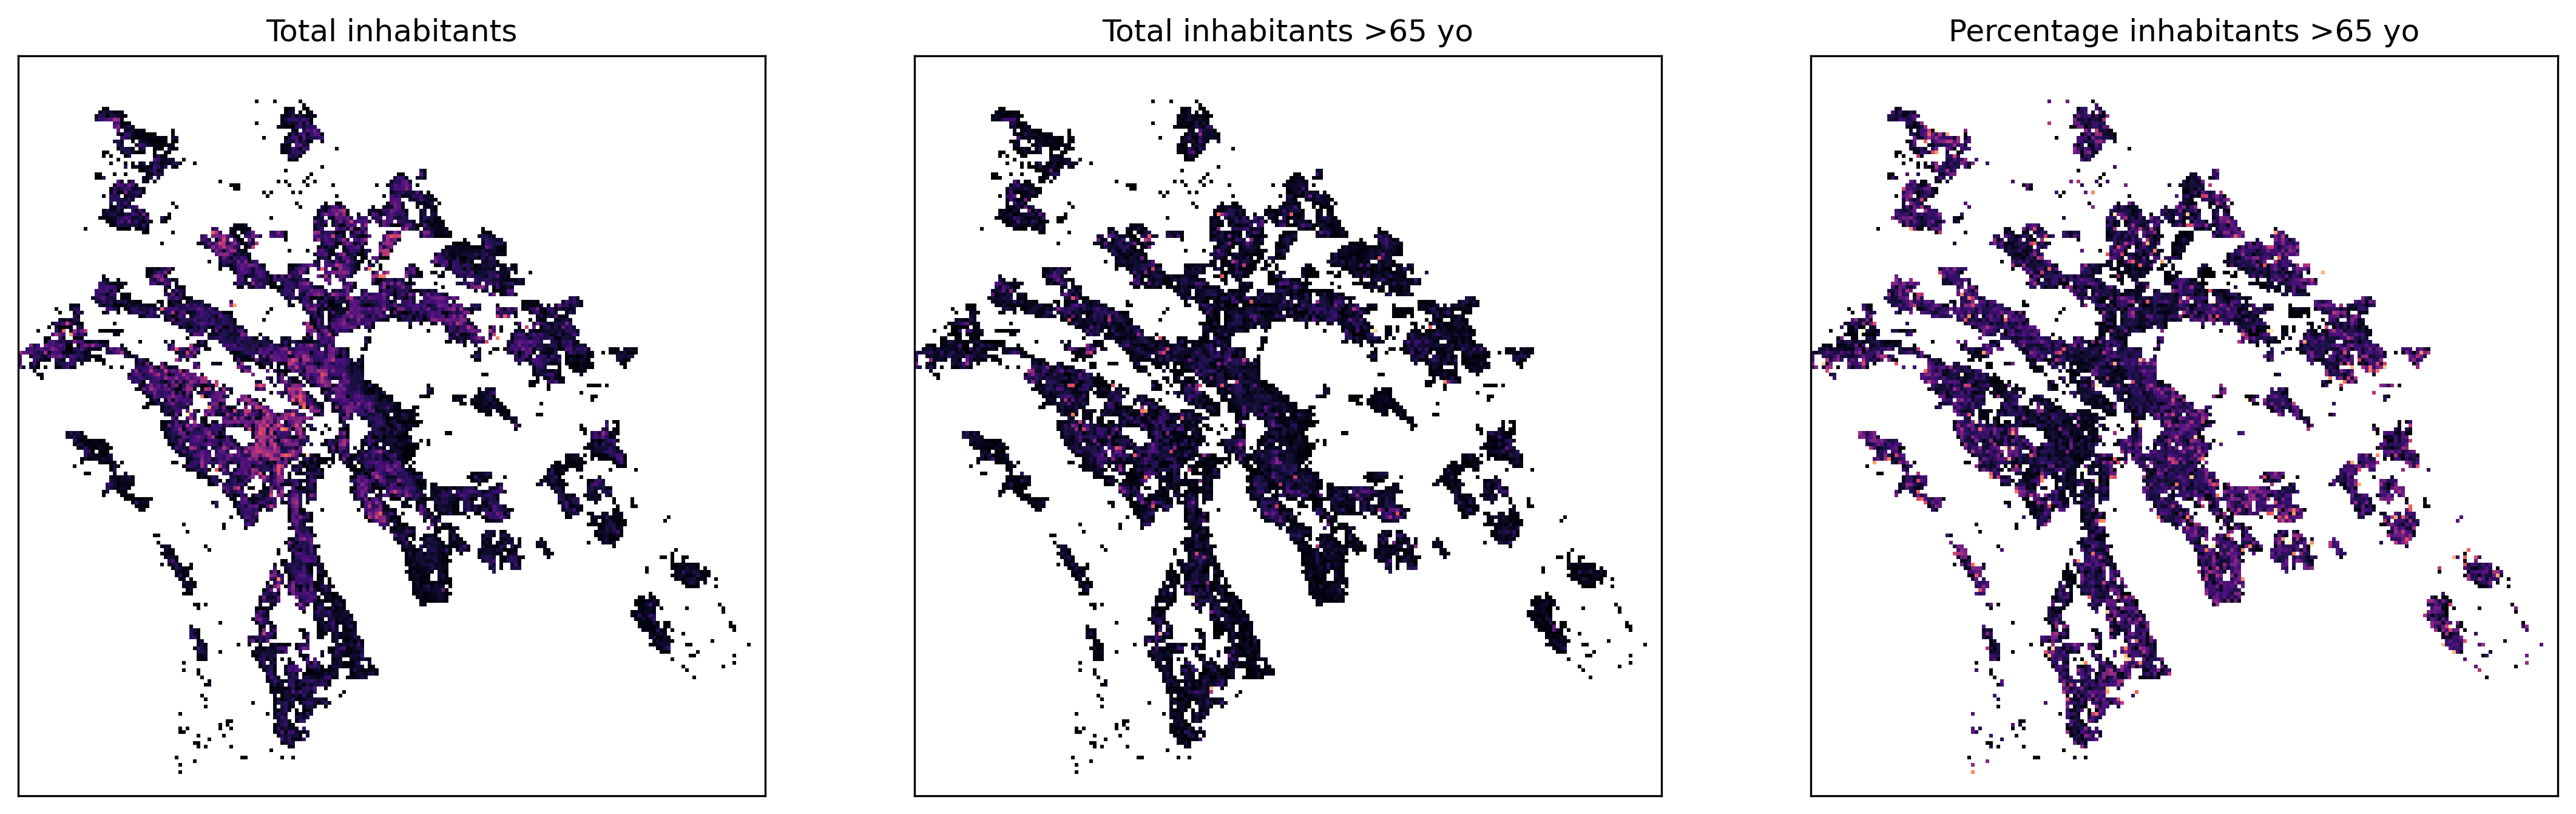

In [153]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

fig, ax = plt.subplots(1, 3, figsize = (18, 6), dpi=300)

t = ls.read(3)
t[t == NODATAVAL] = np.nan
im = ax[0].imshow(t, cmap='magma')
ax[0].set_title('Total inhabitants')

to = ls.read(2)
to[to == NODATAVAL] = np.nan
im = ax[1].imshow(to, cmap='magma')
ax[1].set_title('Total inhabitants >65 yo')

f = ls.read(1)
f[f == NODATAVAL] = np.nan
im = ax[2].imshow(f, cmap='magma')
ax[2].set_title('Percentage inhabitants >65 yo')

for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ls.close()

Mean number of people >65 yo: 12.51182232049948


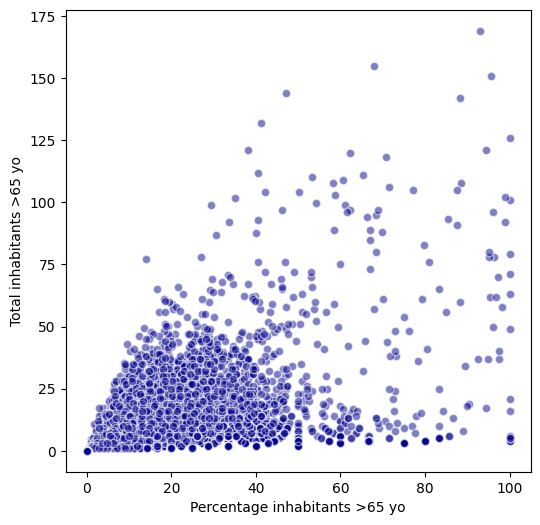

In [159]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

fig, ax = plt.subplots(1, 1, figsize = (6, 6))


to = ls.read(2)
to[to == NODATAVAL] = np.nan

print('Mean number of people >65 yo:', np.nanmean(to.flatten()))

ax.set_ylabel('Total inhabitants >65 yo')

f = ls.read(1)
f[f == NODATAVAL] = np.nan

ax.set_xlabel('Percentage inhabitants >65 yo')

ax.plot(f.flatten(), to.flatten(), 'o', markerfacecolor='darkblue', markeredgecolor='white', alpha=0.5)

ls.close()

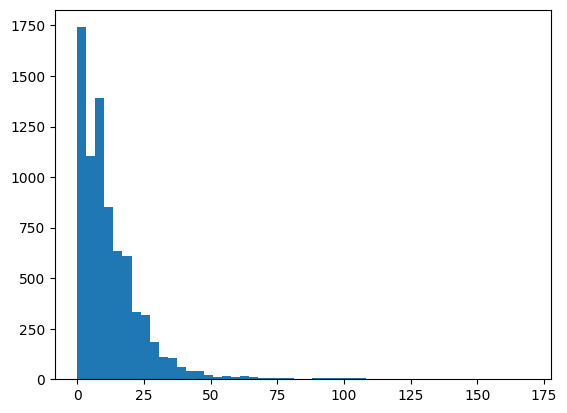

In [167]:
_ = plt.hist(to.flatten(), bins=50)

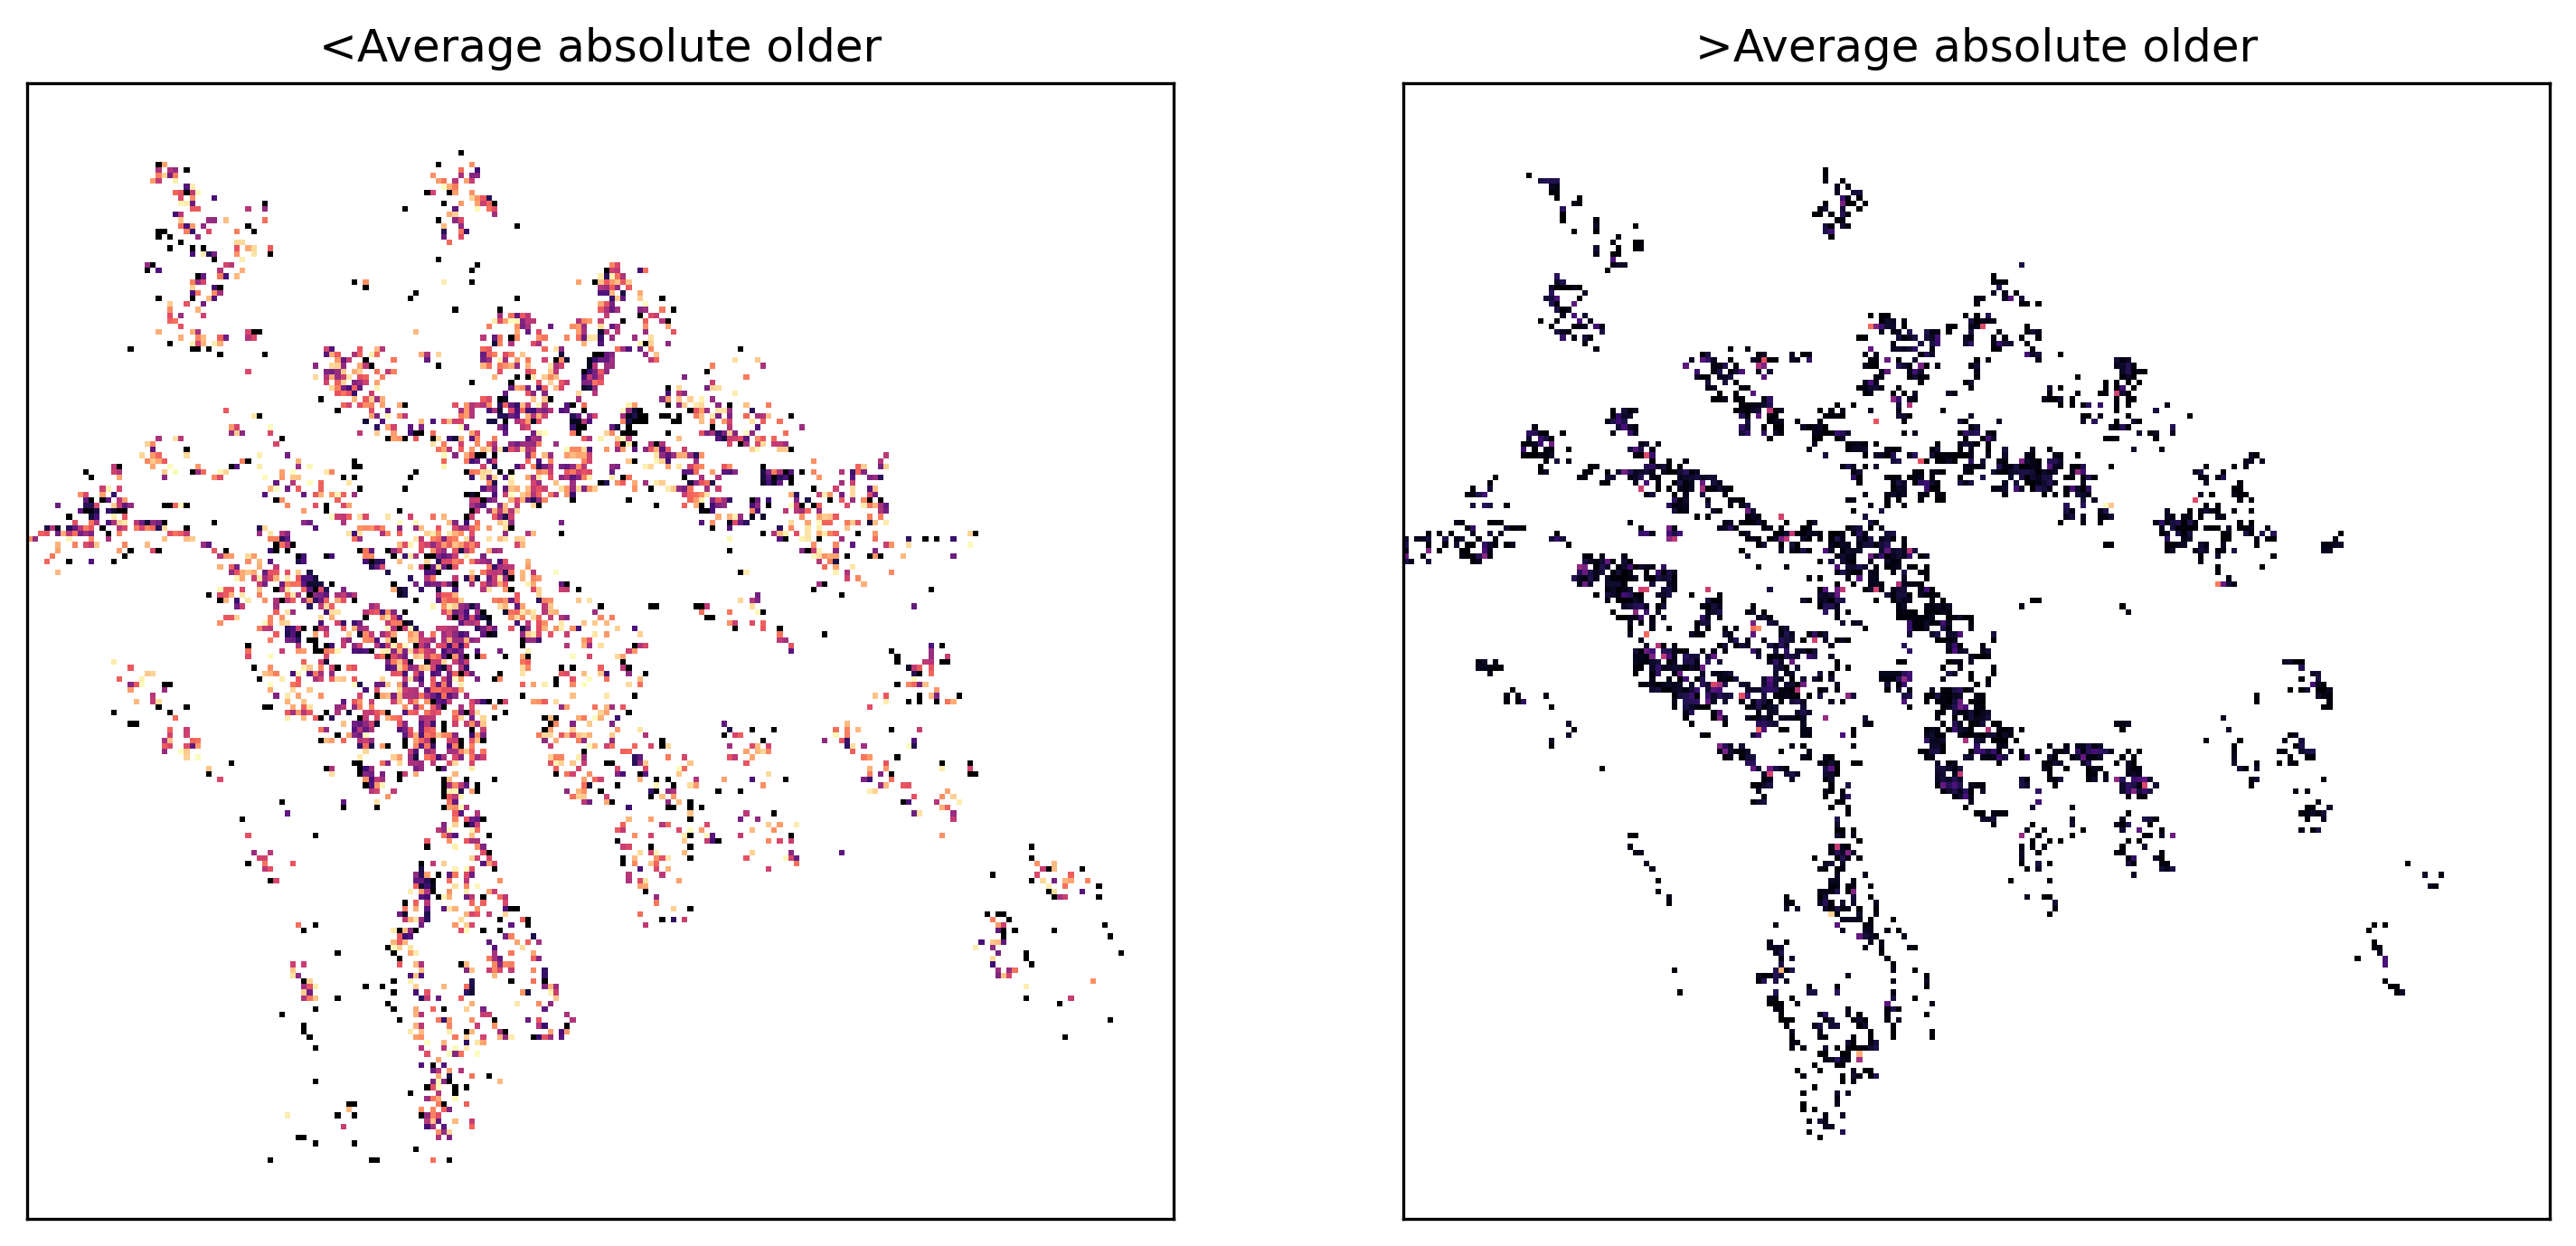

In [173]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(2)
d[d == NODATAVAL] = np.nan

# mask out the younger areas

d[d <= 13] = np.nan

fig, ax = plt.subplots(1, 2, figsize = (12, 6), dpi=300)

im = ax[1].imshow(d, cmap='magma')

ax[1].set_title('>Average absolute older')
ax[1].set_xticks([])
ax[1].set_yticks([])
#ax.set_title('Bevoelkerungsstatistik, percentage >65yo')

#fig.colorbar(im, ax=ax[1])


# Mask out older areas
d = ls.read(1)
d[d == NODATAVAL] = np.nan

d[d > 13] = np.nan

im = ax[0].imshow(d, cmap='magma')

ax[0].set_title('<Average absolute older')
ax[0].set_xticks([])
ax[0].set_yticks([])

ls.close()

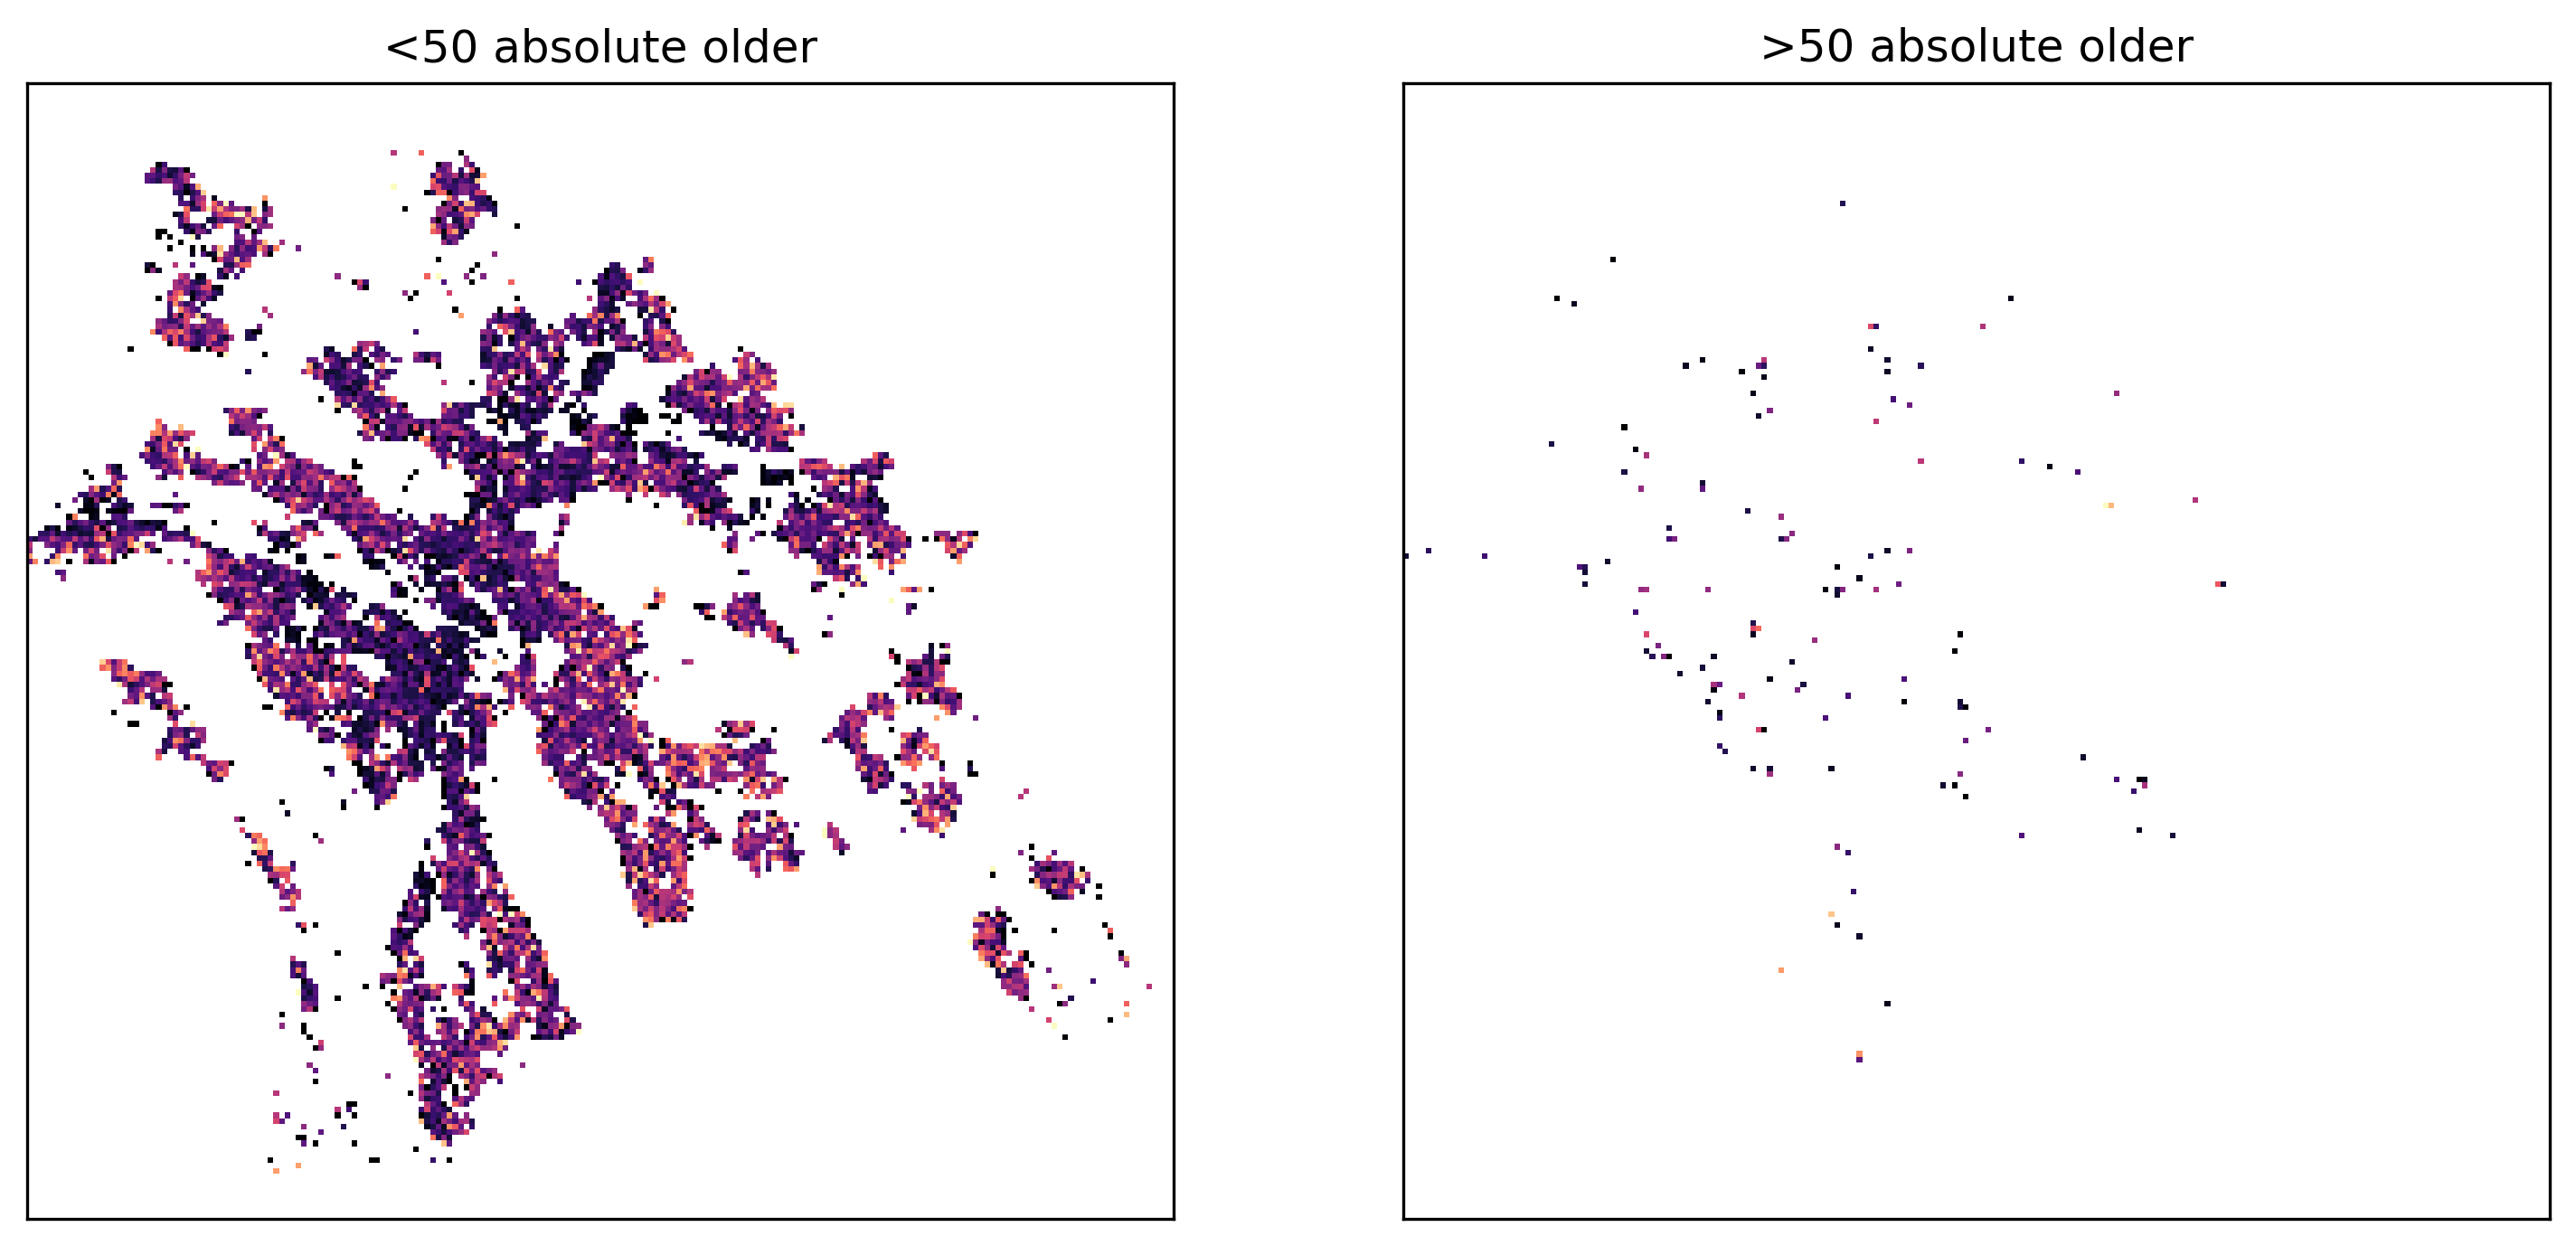

In [172]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(2)
d[d == NODATAVAL] = np.nan

# mask out the younger areas

d[d <= 50] = np.nan

fig, ax = plt.subplots(1, 2, figsize = (12, 6), dpi=300)

im = ax[1].imshow(d, cmap='magma')

ax[1].set_title('>50 absolute older')
ax[1].set_xticks([])
ax[1].set_yticks([])
#ax.set_title('Bevoelkerungsstatistik, percentage >65yo')

#fig.colorbar(im, ax=ax[1])


# Mask out older areas
d = ls.read(1)
d[d == NODATAVAL] = np.nan

d[d > 50] = np.nan

im = ax[0].imshow(d, cmap='magma')

ax[0].set_title('<50 absolute older')
ax[0].set_xticks([])
ax[0].set_yticks([])

ls.close()

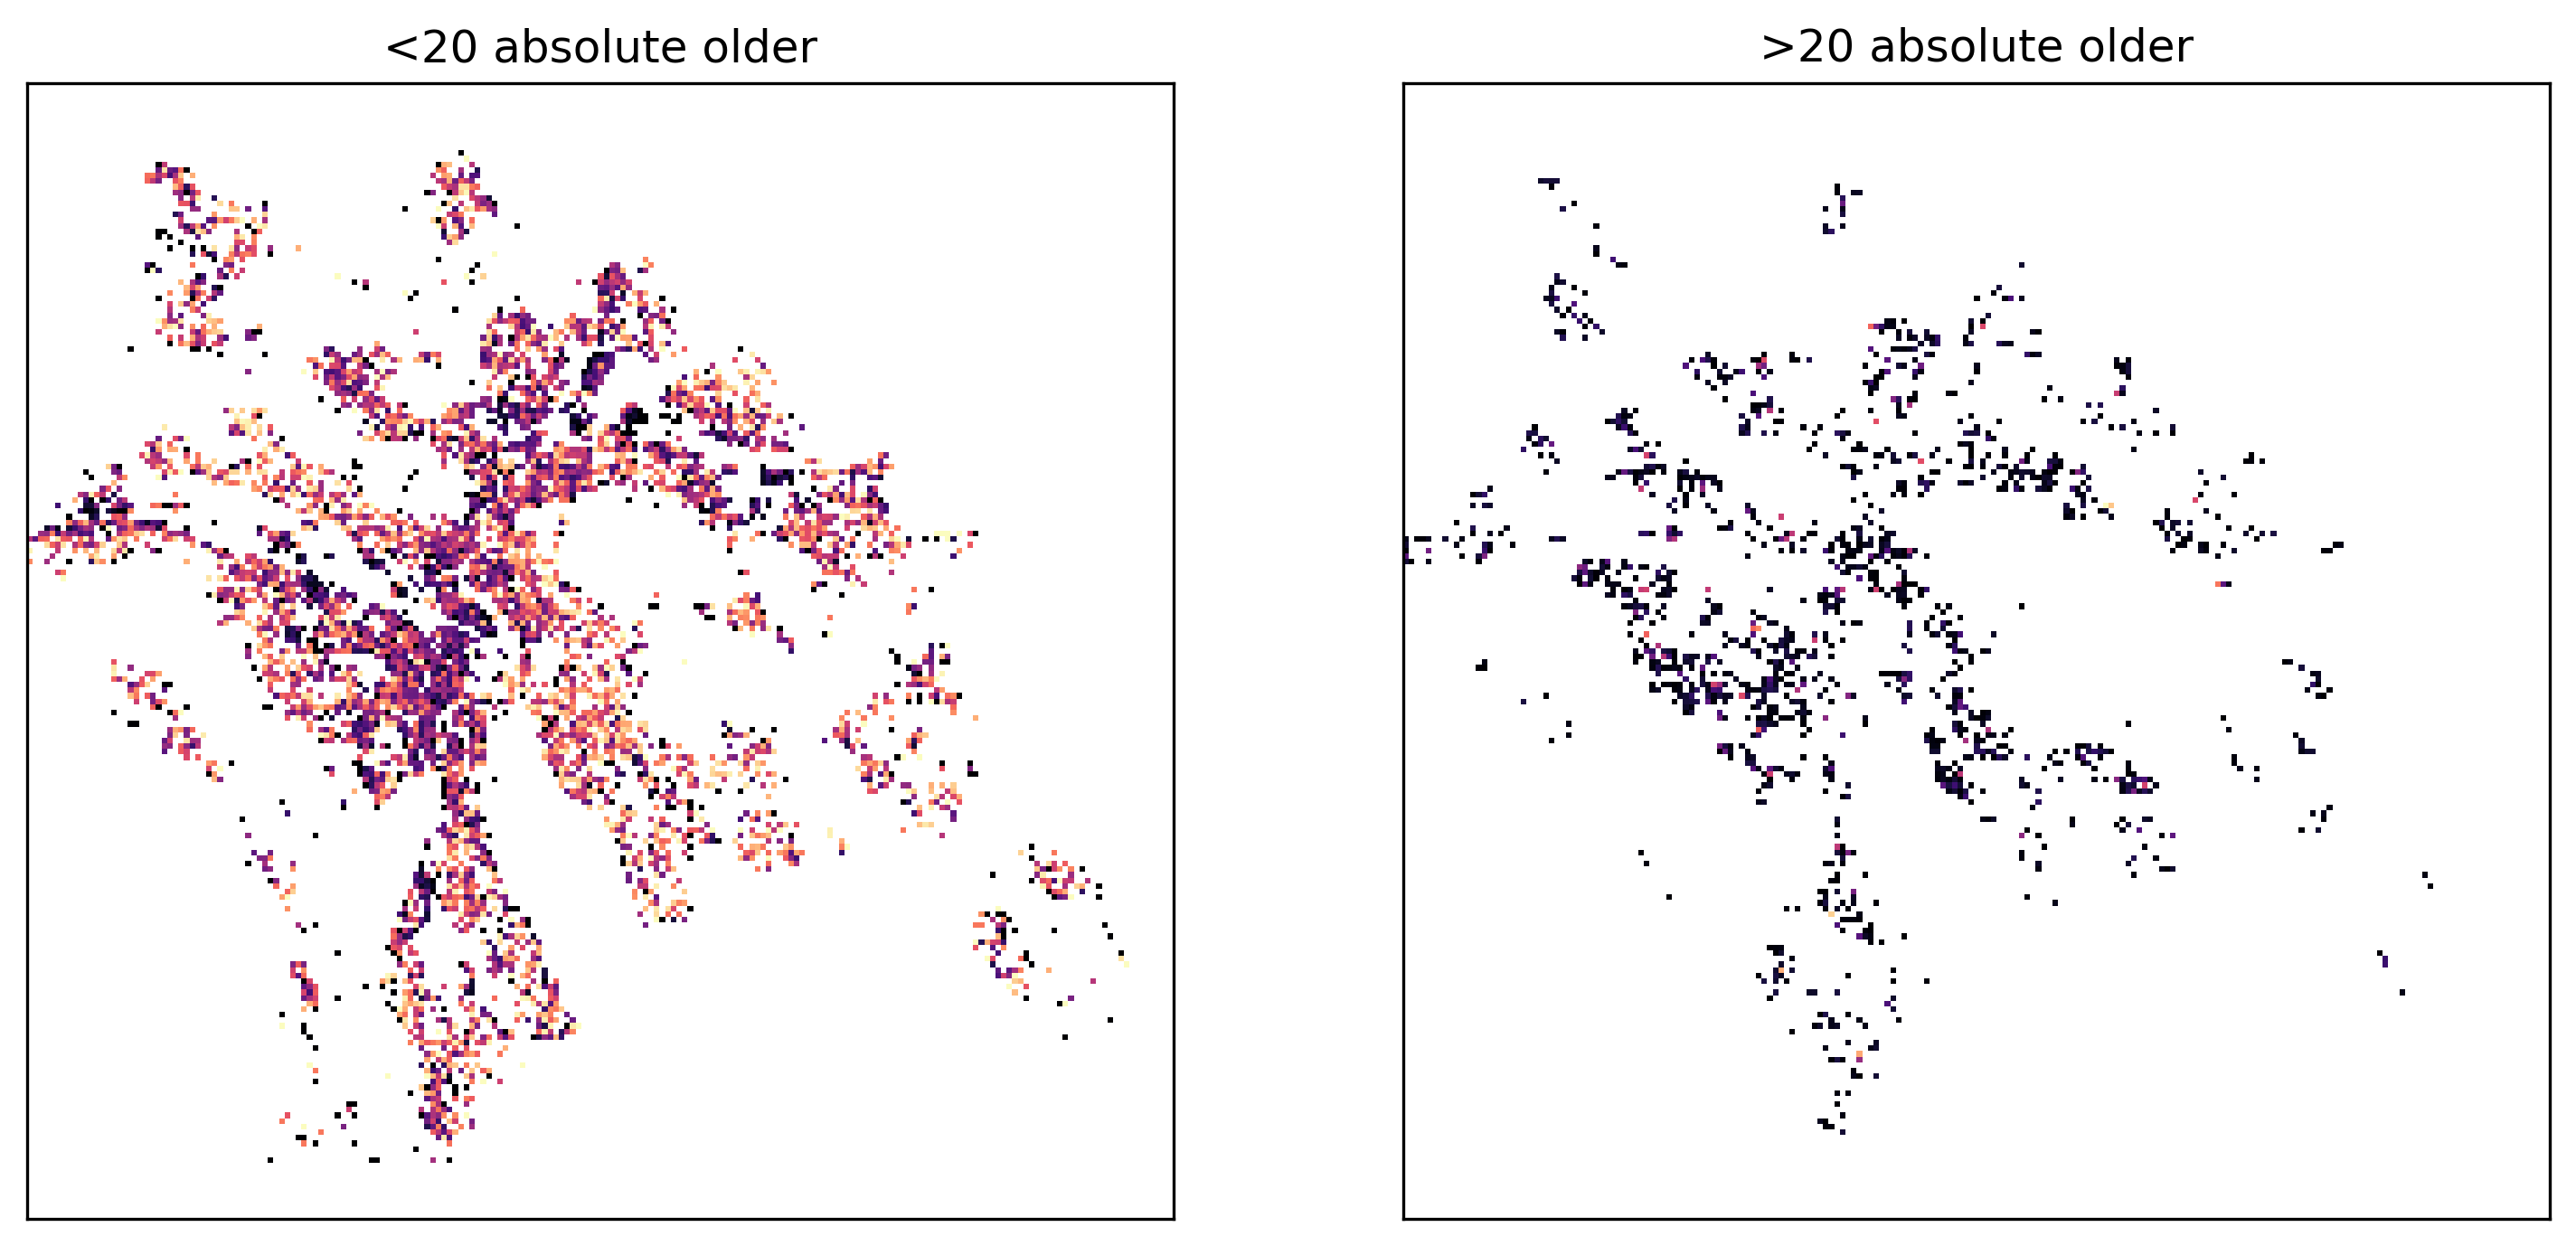

In [171]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(2)
d[d == NODATAVAL] = np.nan
d[d <= 20] = np.nan

fig, ax = plt.subplots(1, 2, figsize = (12, 6), dpi=300)

im = ax[1].imshow(d, cmap='magma')

ax[1].set_title('>20 absolute older')
ax[1].set_xticks([])
ax[1].set_yticks([])

# Mask out older areas
d = ls.read(1)
d[d == NODATAVAL] = np.nan
d[d > 20] = np.nan

im = ax[0].imshow(d, cmap='magma')

ax[0].set_title('<20 absolute older')
ax[0].set_xticks([])
ax[0].set_yticks([])

ls.close()

--> I think it makes the most sense to define areas with lots of old people as those with >25 inhabitants >65 years old. Fractions don't make sense, see above. The histogram suggests that 20 may be a good cut-off, as there is a shoulder in the histogram. It would be nice to be more quantitative about determining this cut-off though.

--> With this, I could go on and intersect the areas with >20 old people with the temperature data, and look which of the intersected areas are the warmest. 

## Intersect temperature and population data for different cut-offs for 'older areas'

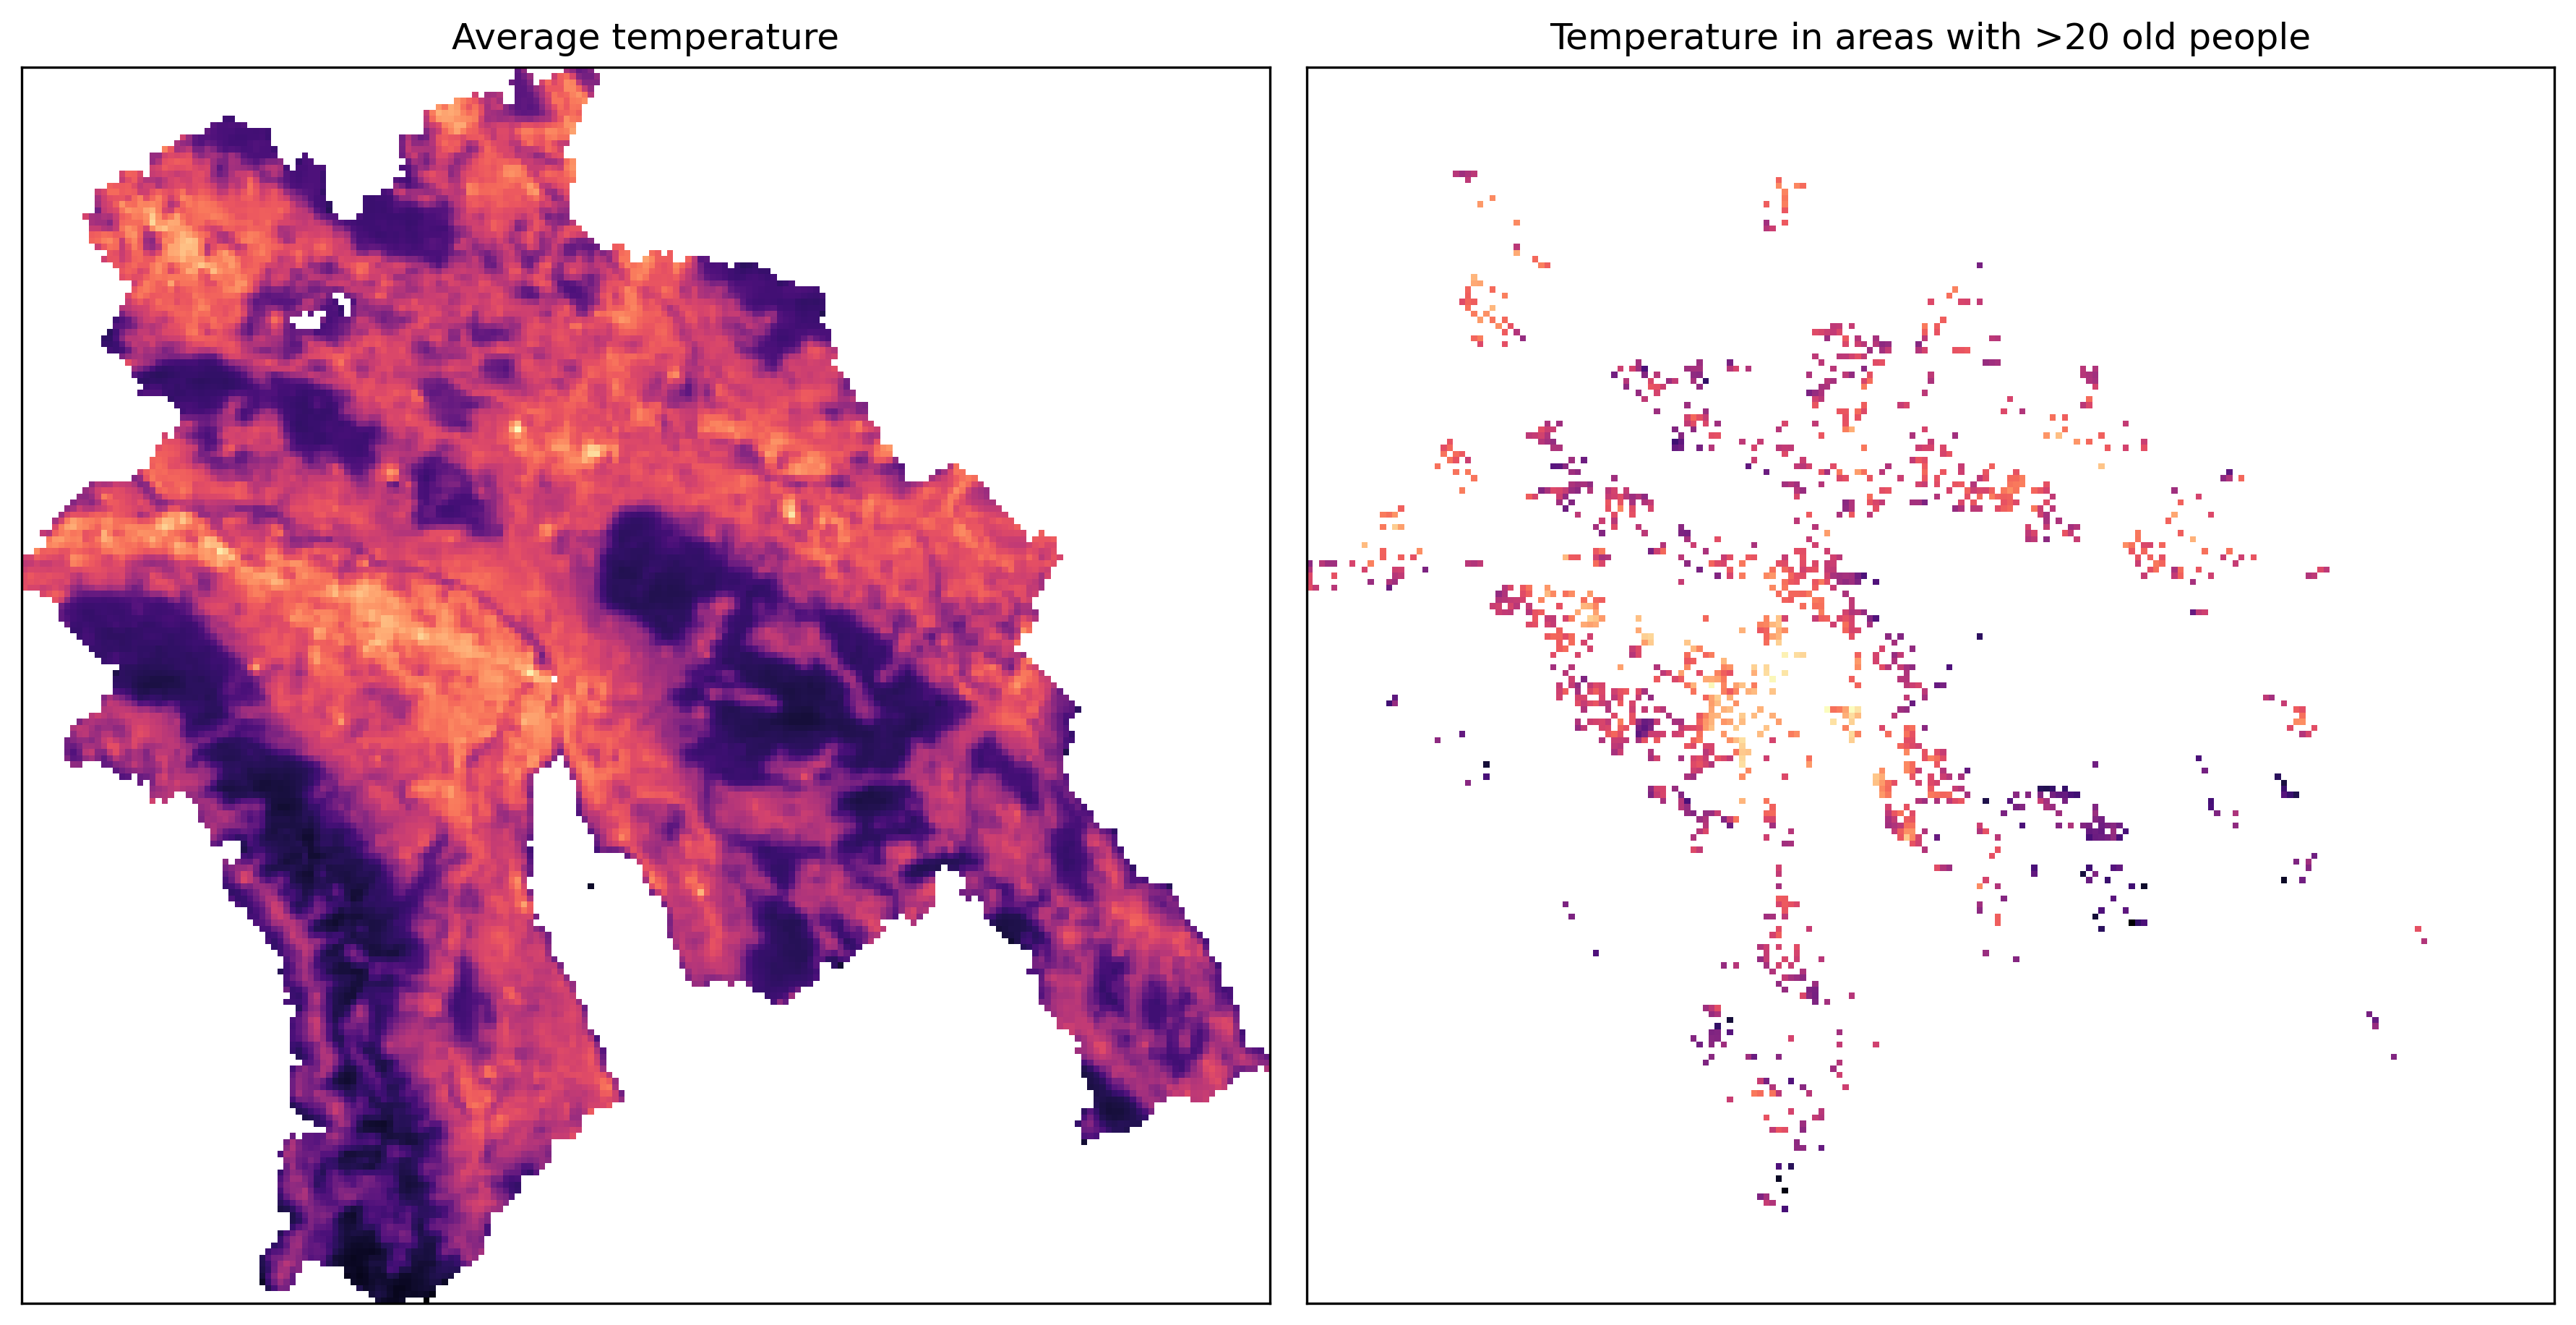

In [189]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(2)
d[d == NODATAVAL] = 1
d[d <= 20] = 1
d[d > 20] = 0

# Average temperature data
lss = rasterio.open('../../data/landsat/resolution/average-resolution.TIF')

l = lss.read(1)
l[l == NODATAVAL] = np.nan

masked = np.ma.masked_array(l, mask=d)

fig, ax = plt.subplots(1, 2, figsize = (12, 6), dpi=300)

im = ax[1].imshow(masked, cmap='magma')
im = ax[0].imshow(l, cmap='magma')

ax[0].set_title('Average temperature')
ax[1].set_title('Temperature in areas with >20 old people')

for i in (0, 1):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()

ls.close()
lss.close()

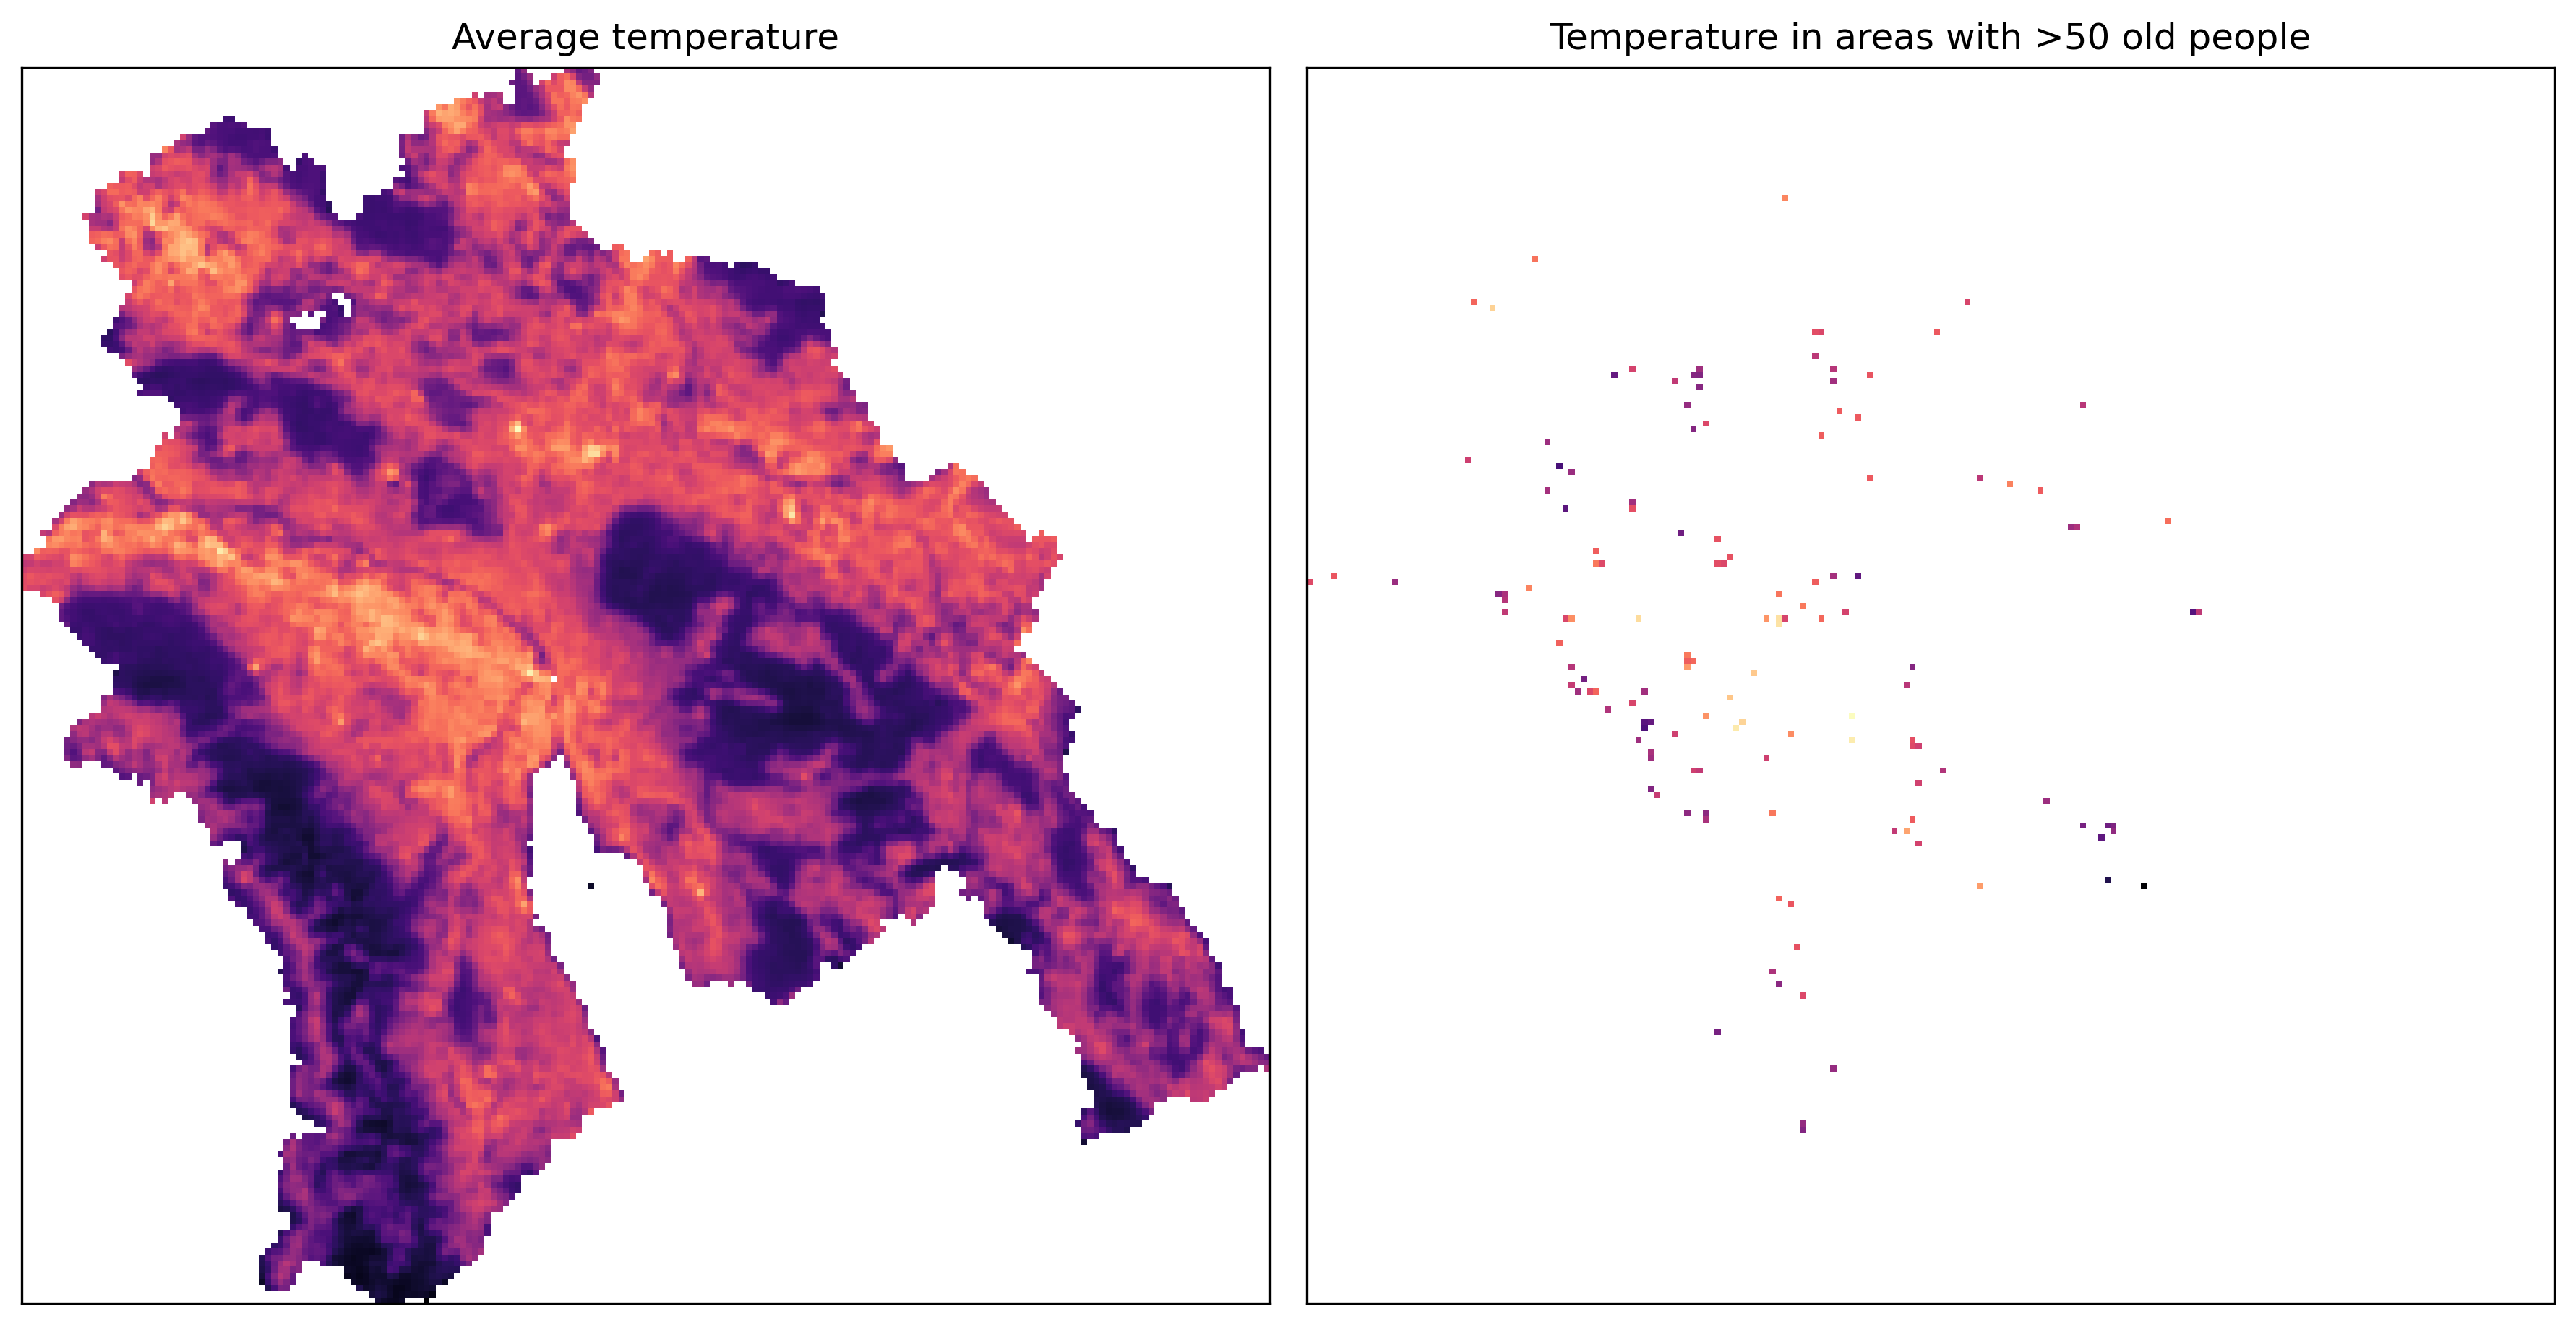

In [191]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(2)
d[d == NODATAVAL] = 1
d[d <= 50] = 1
d[d > 50] = 0

# Average temperature data
lss = rasterio.open('../../data/landsat/resolution/average-resolution.TIF')

l = lss.read(1)
l[l == NODATAVAL] = np.nan

masked = np.ma.masked_array(l, mask=d)

fig, ax = plt.subplots(1, 2, figsize = (12, 6), dpi=300)

im = ax[1].imshow(masked, cmap='magma')
im = ax[0].imshow(l, cmap='magma')

ax[0].set_title('Average temperature')
ax[1].set_title('Temperature in areas with >50 old people')

for i in (0, 1):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()

ls.close()
lss.close()

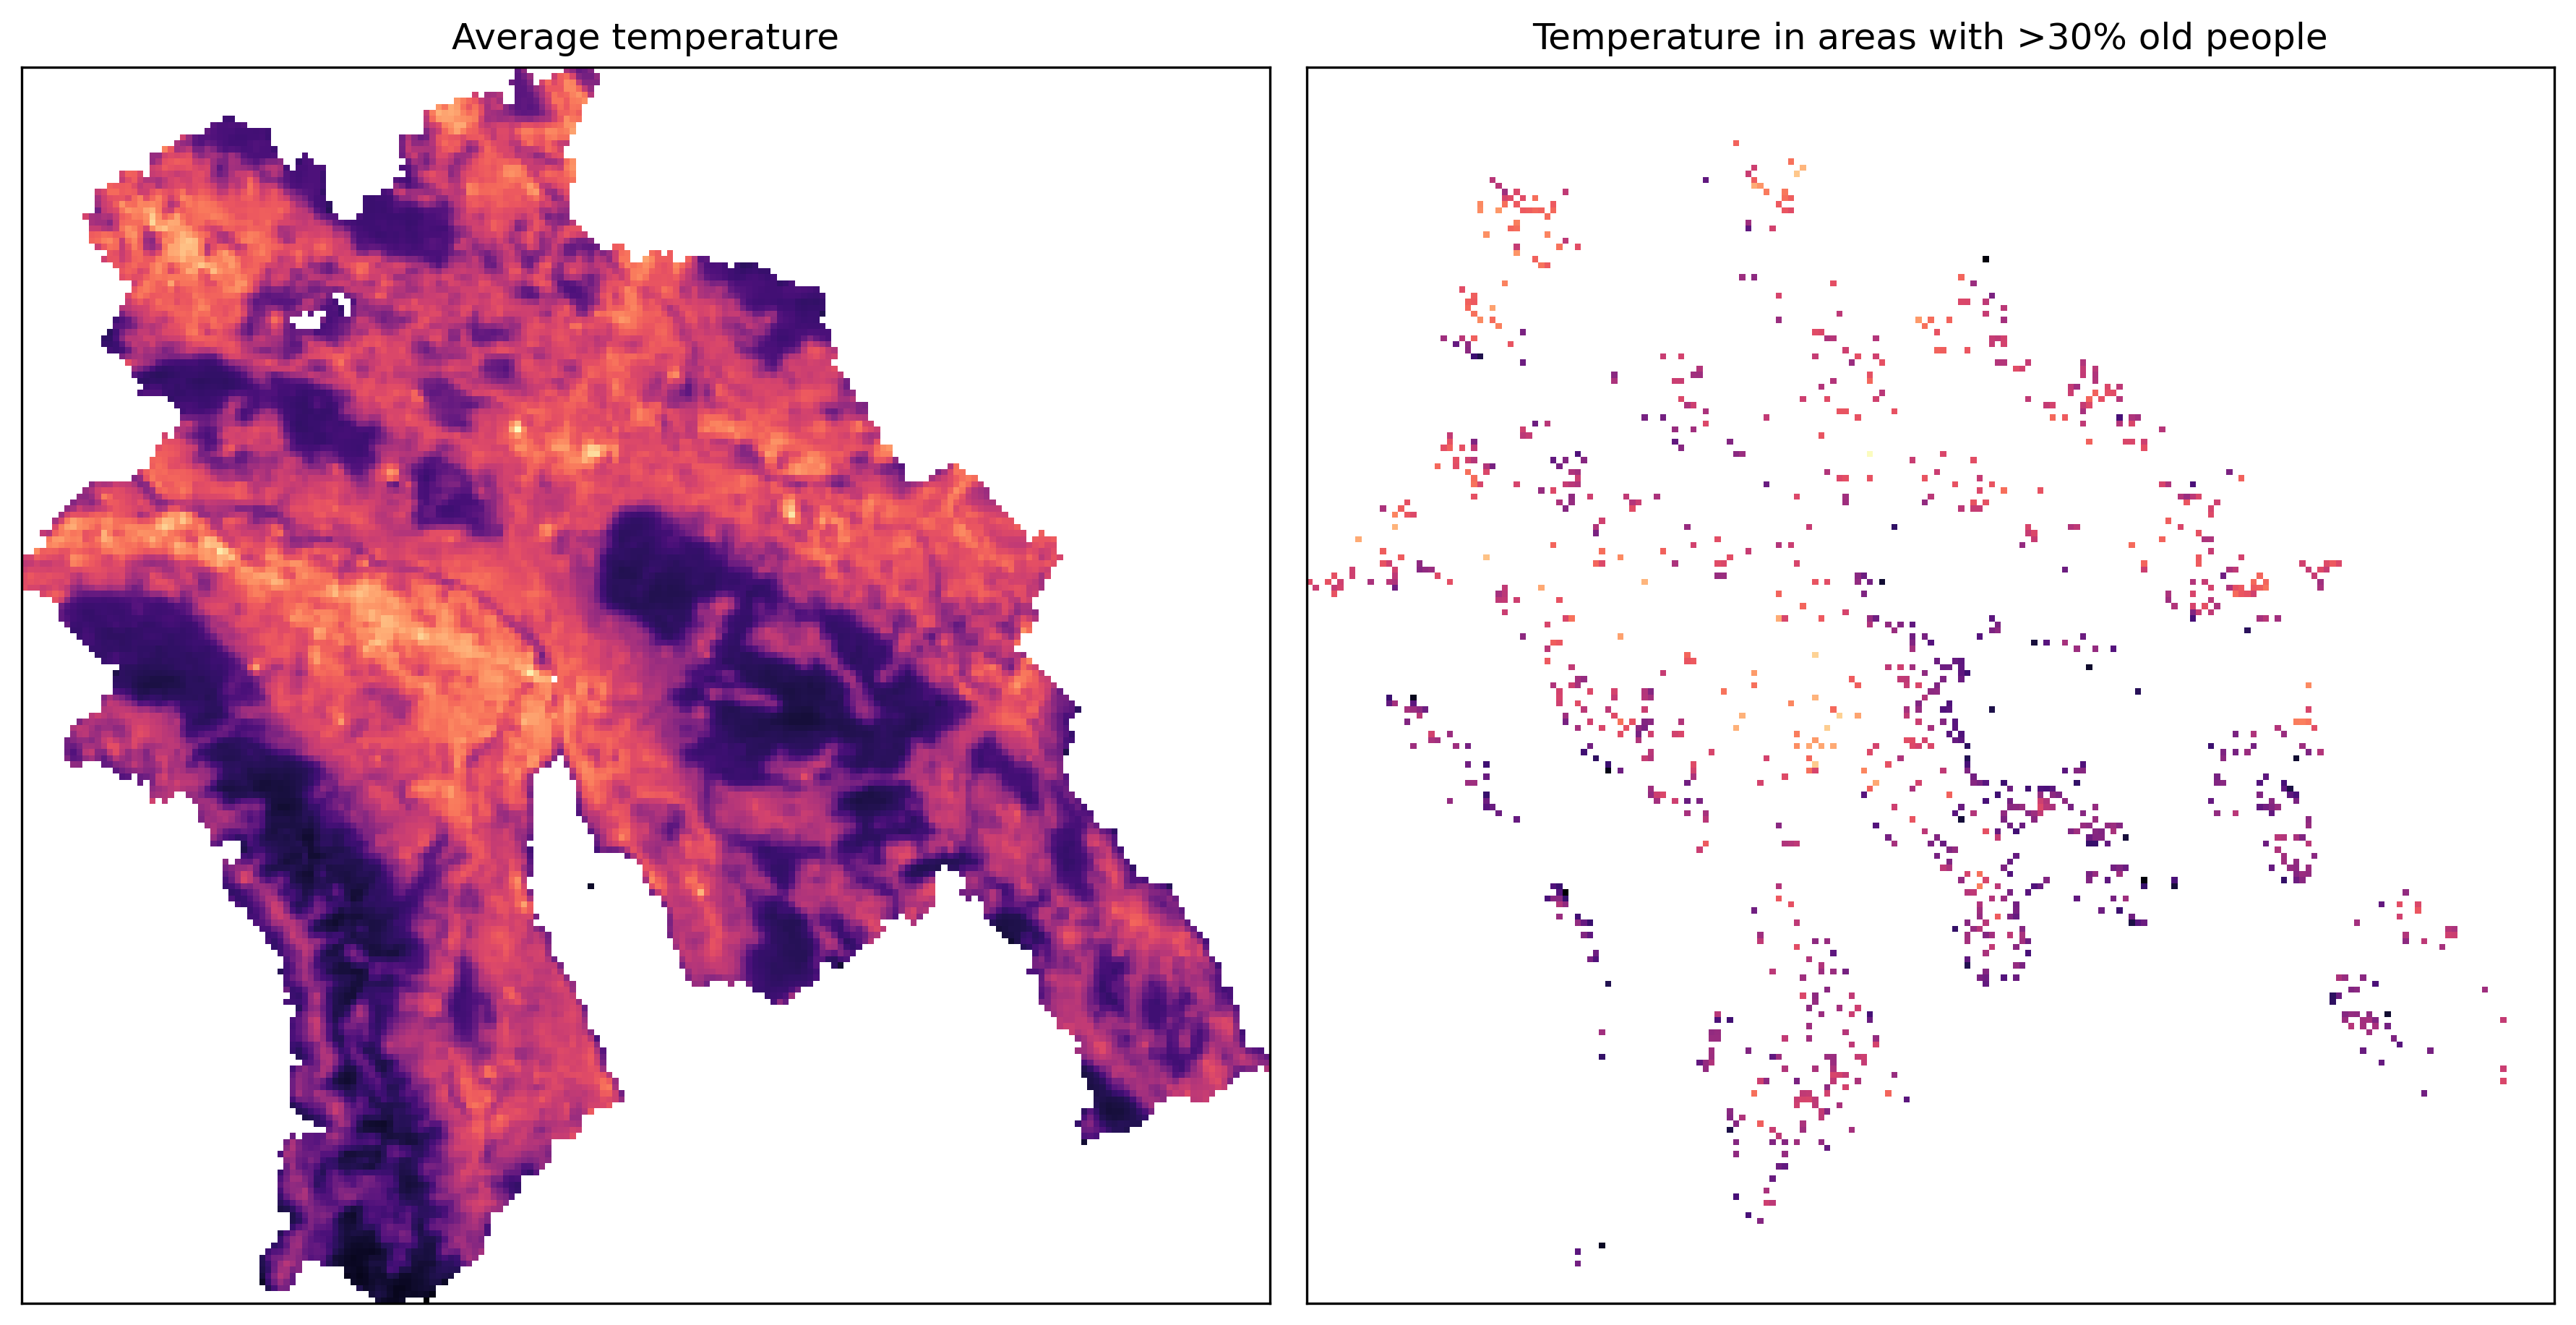

In [190]:
# Population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

d = ls.read(1)
d[d == NODATAVAL] = 1
d[d <= 30] = 1
d[d > 30] = 0

# Average temperature data
lss = rasterio.open('../../data/landsat/resolution/average-resolution.TIF')

l = lss.read(1)
l[l == NODATAVAL] = np.nan

masked = np.ma.masked_array(l, mask=d)

fig, ax = plt.subplots(1, 2, figsize = (12, 6), dpi=300)

im = ax[1].imshow(masked, cmap='magma')
im = ax[0].imshow(l, cmap='magma')

ax[0].set_title('Average temperature')
ax[1].set_title('Temperature in areas with >30% old people')

for i in (0, 1):
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()

ls.close()
lss.close()

--> In general, the areas with older people that are warmer are in the centre and towards Altstetten/Schlieren, Glattbrugg and Regensdorf.

--> Also, just eyeballing where the especially hot areas are in general, it seems like most of them are either football fields or areas with big roofs.

# Make figure for poster

In [4]:
import geopandas as gpd

In [5]:
temps = gpd.read_file(
    "../240420-playing-with-interactive-maps/assets/all-data.json"
)

In [6]:
files = [
 '../../data/landsat/resolution/LC08_L2SP_194027_20220623_20220705_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC08_L2SP_195027_20220716_20220726_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC09_L2SP_194027_20220717_20230407_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC08_L2SP_194027_20220725_20220802_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC08_L2SP_195027_20220801_20220806_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC09_L2SP_194027_20220802_20230404_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC09_L2SP_195027_20220809_20230403_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/LC08_L2SP_194027_20220810_20220818_02_T1_ST_B10-resolution.TIF',
 '../../data/landsat/resolution/average-resolution.TIF']

In [7]:
titles = {
    '20220623': '2022-06-23', 
    '20220716': '2022-07-16', 
    '20220717': '2022-07-17', 
    '20220725': '2022-07-25', 
    '20220801': '2022-08-01', 
    '20220802': '2022-08-02',
    '20220809': '2022-08-09', 
    '20220810': '2022-08-10', 
    'average_temp': 'Durchschnittstemperatur', 
}

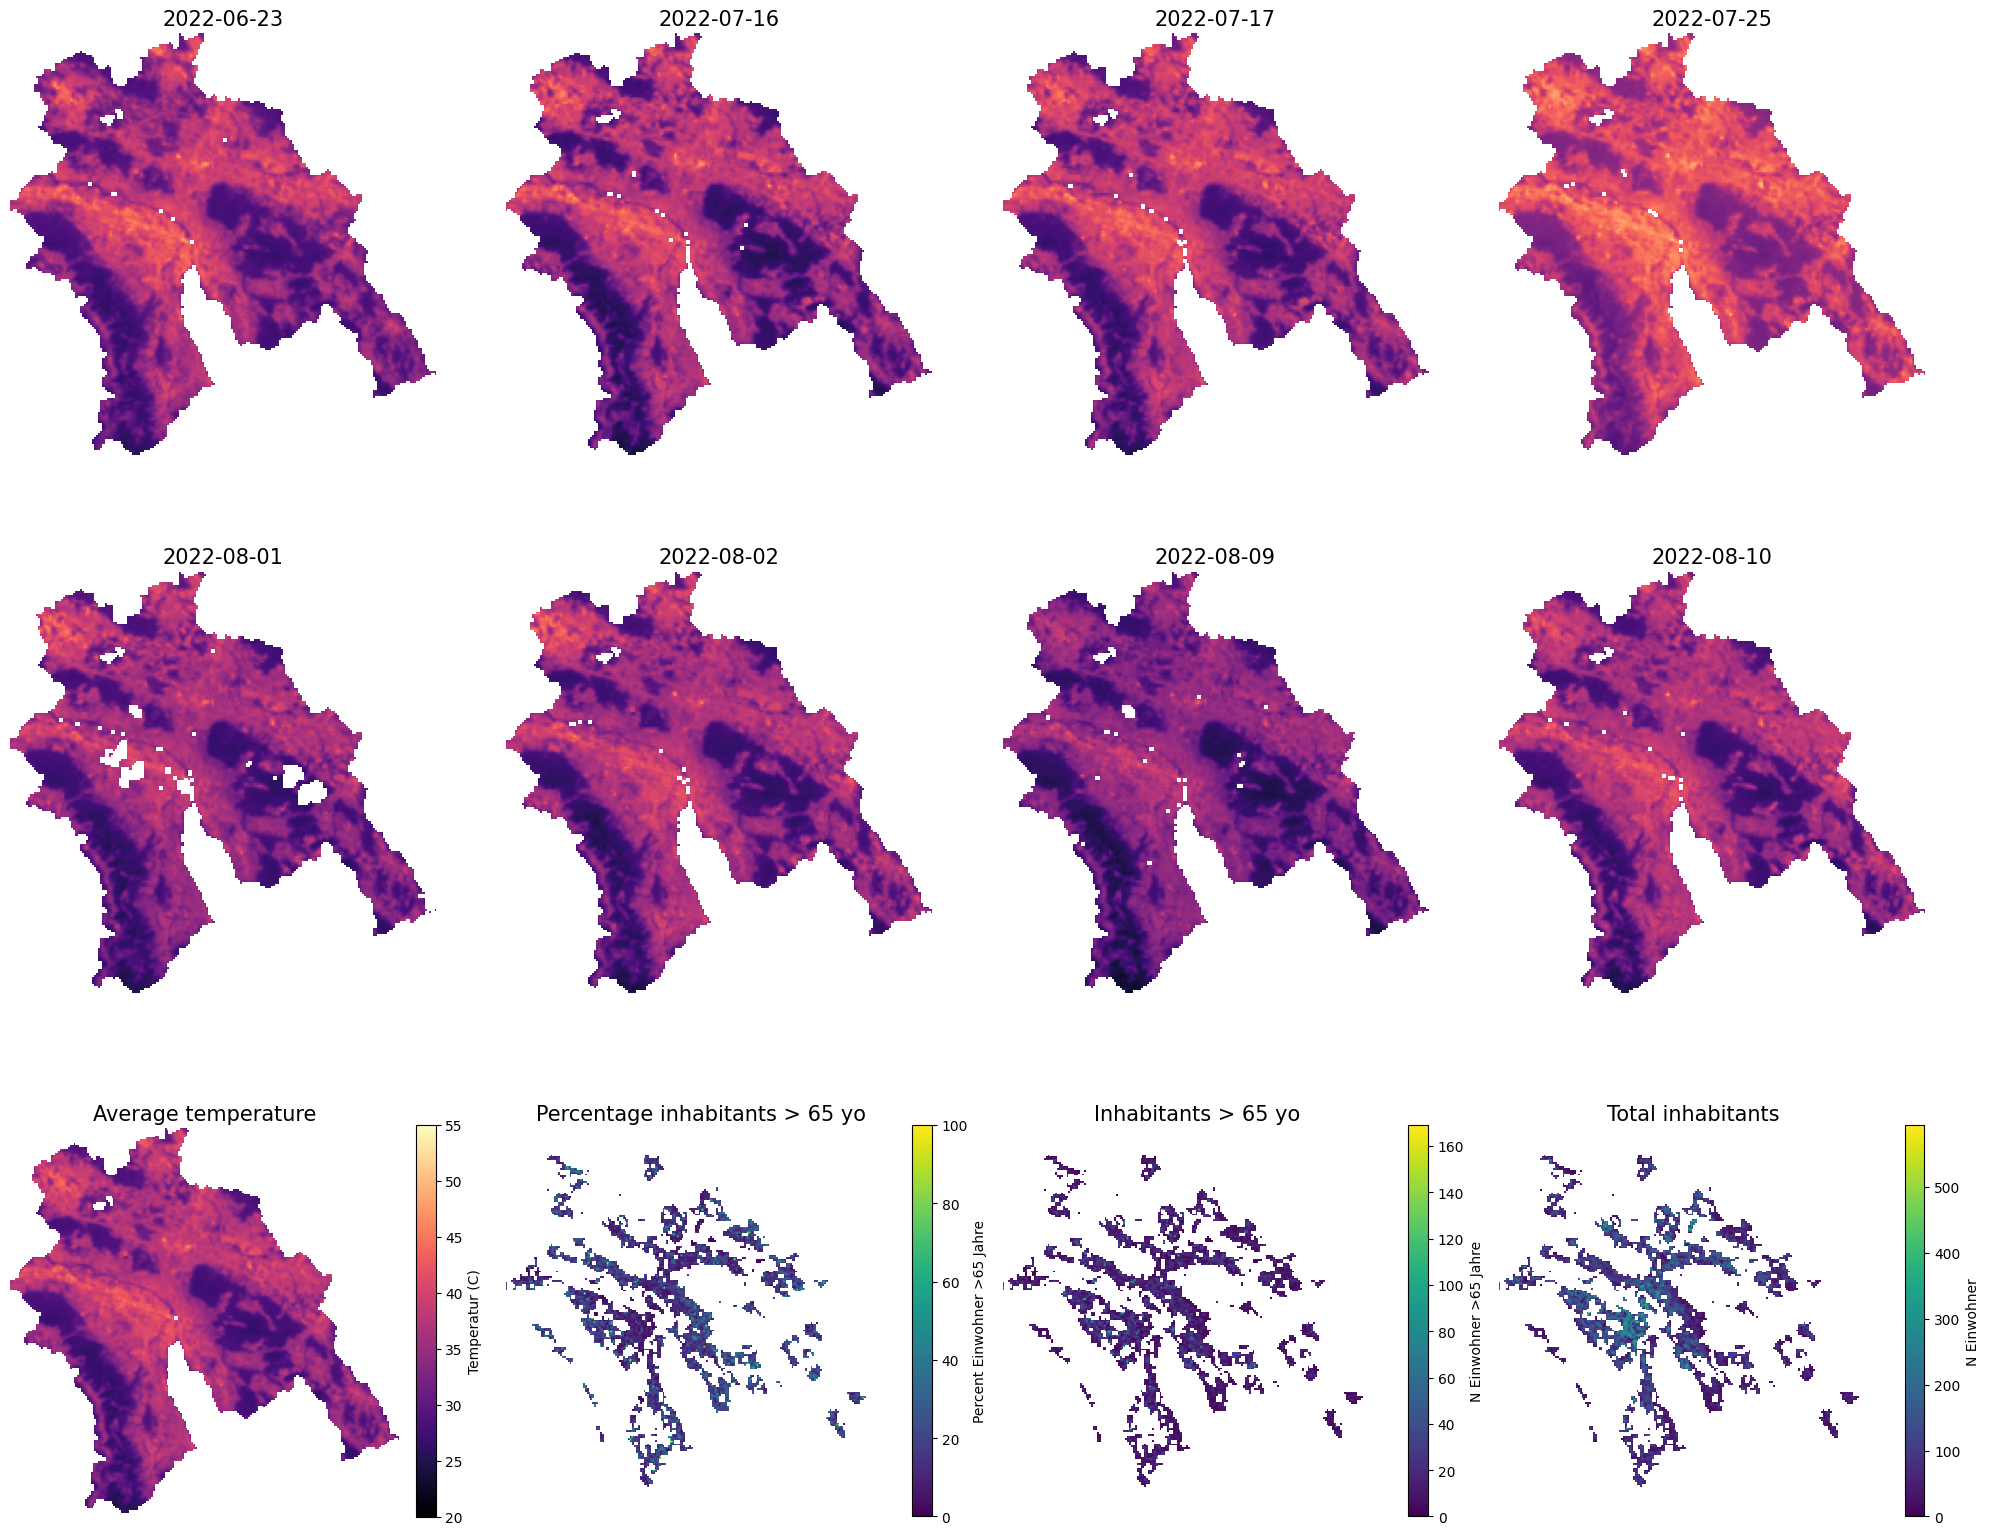

In [26]:
fig, ax = plt.subplots(3, 4, figsize = (20, 16.5))

coords = dimensionalIterator((3, 4))

for file in files:
    row, col = next(coords)
    ls = rasterio.open(file)

    d = ls.read(1)
    d[d == NODATAVAL] = np.nan

    im = ax[row][col].imshow(d, cmap='magma', vmin=20, vmax=55)

    try:
        t = file.split('_')[3]
    except IndexError:
        t = 'average_temp'

    if t == 'average_temp':
        fig.colorbar(im, ax=ax[row][col], fraction=0.046, pad=0.04, label='Temperatur (C)')
    
    ax[row][col].set_xticks([])
    ax[row][col].set_yticks([])
    ax[row][col].set_title(titles[t], fontsize=15)
    ax[row][col].set_axis_off()
    ls.close()

# Plot population data
ls = rasterio.open('../../data/bevoelkerungsstatistik/Raumliche_Bevolkerungsstatistik_-OGD/BEVOELKERUNG_HA_P-raster-clipped.TIF')

# Plot fraction >65
row, col = next(coords)
axi = ax[row][col]

l = ls.read(1)
l[l == NODATAVAL] = np.nan

im = axi.imshow(l, cmap='viridis')
fig.colorbar(im, ax=axi, fraction=0.046, pad=0.04, label='Percent Einwohner >65 Jahre')

axi.set_title('Percentage inhabitants > 65 yo', fontsize=15)


ax[row][col].set_axis_off()

# Plot total > 65 yo
row, col = next(coords)

axi = ax[row][col]

l = ls.read(2)
l[l == NODATAVAL] = np.nan
im = axi.imshow(l, cmap='viridis', vmin=0)
fig.colorbar(im, ax=axi, fraction=0.046, pad=0.04, label='N Einwohner >65 Jahre')
axi.set_title('Inhabitants > 65 yo', fontsize=15)

ax[row][col].set_axis_off()

# Plot total 
row, col = next(coords)

axi = ax[row][col]

l = ls.read(3)
l[l == NODATAVAL] = np.nan
im = axi.imshow(l, cmap='viridis', vmin=0)
axi.set_title('Total inhabitants', fontsize=15)
fig.colorbar(im, ax=axi, fraction=0.046, pad=0.04, label='N Einwohner')
ax[row][col].set_axis_off()

ls.close()

plt.tight_layout()

plt.savefig('temperature-maps.pdf', dpi=500)